# Imports

In [ ]:
import matplotlib.pyplot as plt
from math import exp
from numpy import random as nprand
import numpy as np 
import copy
import random
import math
from datetime import datetime
import time
import pandas as pd
import statistics
import sys

# Logging

This section implements a simple in memory data logger to aid in capturing and displaying data across the different algorithms.

In [ ]:
# import matplotlib.pyplot as plt
# from datetime import datetime

class Logger():
    """
    Conventioned list of metrics to capture across methods:
    - SCORE: how score moves (up / down) throughout the entire run
    - BEST_SCORE: how score improces (just up) throughout the entire run
    - EXEC_TIME: execution time
    """
    methods = {}

    @classmethod
    def log_method(cls, method, params={}):
        cls.methods[method] = {'PARAMS': params, 'METRICS': {}}

    @classmethod
    def log_method_metric(cls, method, override = False, **metrics ):
        for metric, value in metrics.items():
            if metric in cls.methods[method]['METRICS'] and override == False:
                cls.methods[method]['METRICS'][metric].append(value)
            else:
                cls.methods[method]['METRICS'][metric] = [value]

    @classmethod
    def print_method_log(cls, method):
        print(f'METHOD: {method}')
        
        print(f'\tPARAMETERS: {cls.methods[method]["PARAMS"]}')
        
        print('\tMETRICS:')
        for metric, value in cls.methods[method]['METRICS'].items():
            print(f'\t\t{metric}: {value}')


    @classmethod
    def log_time(cls, method, time):
        if time == 'INIT':
            cls.methods[method]['METRICS']['EXEC_TIME'] = datetime.now()
        elif time == 'END':
            if 'EXEC_TIME' in cls.methods[method]['METRICS']:
                cls.methods[method]['METRICS']['EXEC_TIME'] = (datetime.now() - cls.methods[method]['METRICS']['EXEC_TIME']).seconds
            else:
                cls.methods[method]['METRICS']['EXEC_TIME'] = 0
    
    
    @classmethod
    def plot_method_metric(cls, method, metric):
        plt.figure(1, figsize = (13, 5), dpi = 100)
        plt.plot(cls.methods[method]['METRICS'][metric], linewidth=2.0)
        plt.show()


    @classmethod
    def plot_method_metric(cls, method, metric):
        plt.figure(1, figsize = (13, 5), dpi = 100)
        plt.plot(cls.methods[method]['METRICS'][metric], linewidth=2.0)
        plt.show()

    
    @classmethod
    def plot_method_metrics(cls, methods, metrics, dict_consts = None, title = None):

        lmethods = methods if isinstance(methods, list) else [methods]
        lmetrics = metrics if isinstance(metrics, list) else [metrics]

        len_max = 0

        plt.figure(1, figsize = (13, 5), dpi = 100)
        for method in lmethods:
          for metric in lmetrics:
              plt.plot(cls.methods[method]['METRICS'][metric], linewidth=2.0, label = method + " | " + metric)
              len_max = max(len_max, len(cls.methods[method]['METRICS'][metric]))
        
        if dict_consts is not None:
          for const in dict_consts:
                arr_const = np.full(len_max, dict_consts[const])
                plt.plot(arr_const, linewidth=2.0, label = str(const))

        if title is None:
          title = method

        plt.title(title)
        plt.xlabel('Iterations')
        plt.ylabel('Score')
        plt.legend()
        plt.show() 


# Data Model

Below are the key data entities used to represent this problem:

* **Book**: This entity represents a book; it is defined with an id and a score used in the evaluation / fitness of a given solution.
* **Library**: This entity represents a library. It is defined with an id, a sign-up number of days, a scanning daily rate and an ordered collection of Books. The ordering of the books is performed as part of the data loading process. 
* **Problem**: This entity represents a specific scenario where Libraries and Books give shape to the problem’s search space; it is defined with a total number of days for scanning books and a collection of Libraries. It is responsible for i) defining viable random solutions, ii) evaluating a solution and iii) identifying viable neighbors for a given solution.

In [ ]:
#import copy
#import random
#import math

class Book:
    """
    Book class
    :param id: book id
    :param score: book score
    """
    def __init__(self, id, score):
        self.id = id
        self.score = int(score)
    
    def __repr__(self):
        return f'<book: id:{self.id}; score:{self.score}>'

class Library:
    """
    Library class
    :param id: library id
    :param sign_up_days: number of days needed before book scanning can start
    :param daily_scan_rate: number of books that can be scanned in a day
    :param sort_by_score: indicates whether books are ordered by score
    :attrib books: list of books
    """
    def __init__(self, id, sign_up_days, daily_scan_rate, sort_by_score=True):
        self.id = id
        self.sign_up_days = int(sign_up_days)
        self.daily_scan_rate = int(daily_scan_rate)
        self.sort_by_score = sort_by_score
        self.__books = []
        self.score_signup = 0                                                                  
        self.sum_scores = 0                                                                    


    def __repr__(self):
        return f'<library: id: {self.id}; sign_up_days: {self.sign_up_days}; daily_scan_rate: {self.daily_scan_rate}; books: {len(self.books)}>'

    @property
    def books(self):
        return self.__books

    @books.setter
    def books(self, value):
       """ 
       Sets the list of books for a library. 
       List is sorted by score on insert is sorting is enabled.
       :param value: list of books
       """
       self.__books = sorted(copy.deepcopy(value), key = lambda x: x.score, reverse = True) if self.sort_by_score else copy.deepcopy(value)

    def get_books_scores(self, book_position, max_scan_days):
        """ 
        Returns the books and scores, starting from book_position. 
        The number of books select depends on 
            - the number of days avaible for scanning,
            - the scanning rate
            - the number of books in the library

       :param book_position: position from which books will start to be scanned
       :param max_scan_days: number of days up until scanned books' scores will be considered 
       :return book_score: dictionary of scanned books and scores 
       """
       # input validation
        if book_position > len(self.__books) or book_position < 1:
            print('Error: invalid book position')
            raise KeyError

        # input validation
        nr_books = min(len(self.__books), max_scan_days * self.daily_scan_rate)

        if nr_books < 1:
            return {}
       
        # book list rotation to start scanning from book_position
        reordered_books = self.__books[book_position-1:] + self.__books[:book_position-1]

        return {book.id:book.score for book in reordered_books[:nr_books]}

class Problem:
    def __init__(self, scan_days=0, sort_by_score=True):
        self.__scan_days = int(scan_days)
        self.__libraries = {}
        self.sort_by_score = sort_by_score
        self.__init_solution = None

    def __repr__(self):
        return f'<problem: scan_days:{self.scan_days}; libraries: {len(self.libraries)}>'


    @property
    def scan_days(self):
        return self.__scan_days

    @scan_days.setter
    def scan_days(self, value):
        self.__scan_days = int(value)

    @property
    def libraries(self):
        return self.__libraries

    @libraries.setter
    def libraries(self, value):
        """ 
        Sets the dictionary of libraries
       :param value: dictionary of librabries 
       """
        #input validation
        if isinstance(value, dict):
            self.__libraries = value
        else:
            raise TypeError

    @property
    def init_solution(self):
        if self.__init_solution == None:
            self.__init_solution = self.random_solution()
        
        return self.__init_solution

    @init_solution.setter
    def init_solution(self, value):
        self.__init_solution = copy.deepcopy(value)
    
    def load_data(self, filepath):
        """
        Loads libraries and books from file in google hashcode spec format
        Example:
            p1 = Problem()
            p1.load_data('data/example.dat')
        :param filepath: relative path to the data file
        """
        with open(filepath) as f:
            # 0: nr books, 1: nr libs, 2: nr days
            totals_line = f.readline().split()
        
            self.scan_days = totals_line[2]
        
            # 0: score b0, 1: score b1, ...
            book_scores_line = f.readline().split()

            library_id = 0
            books_counter = 0
        
            while True:
                # lib id, 0:nr books, 1:sign up, 2:scan rate
                
                # test EOF
                library_line =  f.readline().split()
                if len(library_line) == 0:
                    break
            
                # 0: book id, 1: book id, ...
                library_books_line = f.readline().split()

                new_library = Library(id=library_id, sign_up_days= library_line[1], daily_scan_rate= library_line[2], sort_by_score=self.sort_by_score)
                new_books = []

                sum_scores = 0                                                                                                
                for book_id in library_books_line:
                    new_books.append(Book(id=book_id, score=int(book_scores_line[int(book_id)])))
                    sum_scores += int(book_scores_line[int(book_id)])                                               
                
                new_library.sum_scores =  sum_scores                                                                
                new_library.score_signup =  sum_scores/new_library.sign_up_days                                     
                new_library.books = new_books
                books_counter += len(new_books)
                self.libraries[library_id] = new_library
                library_id +=1
        
        
        nr_libs = library_id
        avg_nr_book = int(books_counter / nr_libs)
        print(f'load completed\nnr. of libraries: {nr_libs}\naverage nr. of books: {avg_nr_book}')

        # check for duplicate books in a same library
        for lib in self.libraries.values():
            book_ids = [book.id for book in lib.books]
            if len(set(book_ids)) != len(book_ids):
                print(f'warning: library {lib.id} has duplicate books!')

        return nr_libs, avg_nr_book                                                                                         
        # estimated search space, assuming average nr of books: B!^(L) x L!
        # search_space = pow(math.factorial(avg_nr_book),nr_libs)*math.factorial(nr_libs)
        # print(f'estimated search space: {search_space:0.3E}')


    def score_solution(self, solution):
        """
        Calculates the total score of a given solution by taking into account
        - the time needs for signing up
        - each library's daily scanning rate
        - the number of day up until books can be scanned
        - a book as the same score across librabries
        - a score is not considered more than once in case of repeated books
        - invalid libraries / book positions will have 0 score

        :param solution: list of tuples (library_id, book_position)
        """
        sign_up_delay = 0
        all_scores = {}

        for library_id, book_position in solution:
            try:
                sign_up_delay += self.libraries[library_id].sign_up_days
                max_scan_days = self.scan_days - sign_up_delay

                if max_scan_days <=0:
                    break
           
                all_scores |= self.libraries[library_id].get_books_scores(book_position, max_scan_days)
            except KeyError:
                print('Error: Invalid parameters, 0 score.')
                # solutions with invalid parameters will get 0 score'
                all_scores = {}
                break

        return sum(all_scores.values())


    def random_solution(self):
        """
        Generates random sequences of libraries with a random first book

        :return list of tuples (library_id, book_position)
        """
        solution = []
        for library_id in random.sample(list(self.libraries.keys()), len(self.libraries)):
            book_position = random.randint(1, len(self.libraries[library_id].books))
            solution.append((library_id, book_position))

        return solution



    def search_space(self):
        """
        Computes the search space of the problem

        :return space, space_reduced
        """
        libs_perm = math.factorial(len(self.libraries))
        space = libs_perm
        space_reduced = libs_perm

        #print(self.libraries)
        for library in self.libraries:
            space = space * math.factorial(len(self.libraries[library].books)) 
            space_reduced = space_reduced * len(self.libraries[library].books)
            #print(len(self.libraries[library].books))

        alpha = math.log10(libs_perm) / math.log10(space_reduced)

        return math.log10(space), math.log10(space_reduced), alpha
    
    def score_signup_solution(self):
        """
        Generates a sequence of libraries with a list of books sorted by decreasing score
        The libraries are sorted by decreasing ratio (sum of books score / signup time)

        :return list of tuples (library_id, book_position)
        """
        solution = []

        sorted_list = sorted(self.libraries.values(), key = lambda x: (-x.score_signup, -x.sum_scores, -x.daily_scan_rate))

        for library in sorted_list:
            solution.append((library.id, 1))
        
        return solution

    
    def signup_solution(self):
        """
        Generates a sequence of libraries with a list of books sorted by decreasing score
        The libraries are sorted by decreasing ratio (sum of books score / signup time)

        :return list of tuples (library_id, book_position)
        """
        solution = []

        sorted_list = sorted(self.libraries.values(), key = lambda x: (x.sign_up_days, -x.sum_scores, -x.daily_scan_rate))

        for library in sorted_list:
            solution.append((library.id, 1))
        
        return solution


    def rotate_books(self, solution, library_idx, nr_rotations=1):
        '''
        Makes n rotations for a given list of books
        Example:
           [A B C D] with 1 rotation becomes [B C D A]
           [A B C D] with 2 rotation2 becomes [C D A B]

        :param solution: list of tuples (library_id, book_position)
        :param: library_idx: the index of the library which books will rotate
        :param: nr_rotations: the number of rotations in the books list
        :returns new solution with nr_rotations on books from library in library_idx
        '''
        library_id , book_position = solution[library_idx]
        nr_books = len(self.libraries[library_id].books)

        new_position = book_position
        new_solution = copy.deepcopy(solution)

        # if the number of rotations is bigger than the number of books 
        # we need to discount the number of full rotations
        if nr_rotations + book_position > nr_books:
            new_position = 1 + ((nr_rotations + book_position) % nr_books)
        else:
            new_position = nr_rotations + book_position

        new_solution[library_idx]=(library_id,new_position)

        return new_solution

    def rotate_libraries(self, solution, nr_rotations=1):
        '''
        Makes n rotations for a given list of libraries
        Example:
           [A B C D] with 1 rotation becomes [B C D A]
           [A B C D] with 2 rotation2 becomes [C D A B]

        :param solution: list of tuples (library_id, book_position)
        :param: nr_rotations: the number of rotations in the library list
        :returns new solution with nr_rotations on libraries
        '''
        nr_libraries = len(self.libraries)
        library_ind = 0
        new_solution = copy.deepcopy(solution)

        # if the number of rotations is bigger than the number of libraries 
        # we need to discount the number of full rotations
        if nr_rotations >= nr_libraries:
            library_ind = nr_rotations % nr_libraries
        else:
            library_ind = nr_rotations

        return new_solution[library_ind:]+new_solution[:library_ind]

    def swap_libraries(self, solution, library_idx, step_size=1):
        """
        Swap library in index library_idx with library step_size away from it
        Example:
           [A B C D] after swaping library in library_idx=0 with step_size = 3 results in [D B C A]

        :param solution: list of tuples (library_id, book_position)
        :param: library_idx: the index of the library that will be swapped
        :param: step_size: distance between library_idx and the other librabry in the swap
        :returns new solution with swapped libraries libraries
        """
        new_solution = copy.deepcopy(solution)
        pos1 = library_idx
        distance = library_idx + step_size

        # a flip can be to a position on the left but not farther than 0
        # a flip can be to a position on the right but not farther than len -1
        pos2 = min(max(distance,0), len(self.libraries)-1)

        # swap libraries
        new_solution[pos1],new_solution[pos2] = new_solution[pos2],new_solution[pos1]

        return new_solution
        
    def neighbour_solution(self, solution, step_size = 1):
        """
        Generate a neighbour solution for a given solution by
        - rotating the libraries up to step_size times
        - rotating the books in a library up to step_size times
        - swaping two libraries apart up to step_size positions

        :param solution: list of tuples (library_id, book_position)
        :param: step_size: notional distance between current solution and desired solution
        :returns new solution after rotating and swapping
        """
        nr_libraries = len(self.libraries)
        rand_library_idx1 = random.randint(0, nr_libraries-1)     
        rand_book_rotations = random.randint(1, step_size)
        rand_librabry_rotations = random.randint(1, step_size)
        # swapping can be to the left or right
        rand_swap_distance = random.randint(-step_size, step_size)

        sol1 = self.rotate_books(solution, rand_library_idx1, rand_book_rotations)
        sol2 = self.rotate_libraries(sol1, rand_librabry_rotations)
        sol3 = self.swap_libraries(sol2, rand_library_idx1, rand_swap_distance)

        return sol3

    def print_all(self):
        for lib in self.__libraries.values():
            print(lib)
            for bk in lib.books:
                print('\t',bk)

**Note:** for the analysis below, the simulated annealing and tabu search will use a common random initial solution.

In [ ]:
#common random solution from file b:
RAND_SOL_B = [(37, 359), (94, 550), (28, 889), (91, 447), (66, 648), (38, 777), (20, 859), (78, 791), (23, 883), (80, 47), (53, 169), (57, 756), (51, 791), (29, 399), (95, 81), (83, 720), (42, 809), (72, 53), (58, 666), (43, 93), (45, 377), (86, 212), (89, 907), (39, 409), (18, 379), (67, 366), (70, 782), (12, 188), (27, 936), (77, 746), (99, 713), (64, 323), (1, 483), (30, 555), (0, 989), (36, 168), (50, 533), (92, 720), (88, 488), (52, 563), (63, 526), (56, 476), (65, 22), (16, 501), (44, 738), (3, 802), (61, 843), (7, 950), (26, 827), (22, 217), (87, 403), (75, 890), (69, 1000), (74, 969), (59, 918), (21, 300), (49, 232), (81, 706), (35, 693), (41, 163), (11, 225), (6, 988), (76, 19), (85, 521), (60, 509), (24, 339), (8, 803), (32, 632), (68, 966), (96, 382), (33, 996), (98, 11), (73, 852), (54, 764), (9, 810), (40, 197), (62, 657), (25, 260), (4, 491), (31, 977), (15, 543), (13, 675), (84, 69), (47, 354), (5, 505), (19, 266), (48, 434), (90, 299), (14, 185), (97, 701), (79, 546), (17, 583), (71, 787), (82, 667), (10, 911), (34, 37), (46, 33), (55, 956), (93, 392), (2, 518)]

# Deterministic Solutions

In [ ]:
# Exploratory analysis of deterministic solutions
files = ['a_example', 'b_read_on','c_incunabula', 'd_tough_choices', 'e_so_many_books', 'f_libraries_of_the_world', 'z_knownsolution']
path_data = 'data/'

rows_list = []
for file in files:
    filename = path_data + file + '.txt'

    print(file)

    problem_TS = Problem()

    nr_libs, avg_nr_book = problem_TS.load_data(filename)

    score_signup_value = problem_TS.score_solution(problem_TS.score_signup_solution())

    signup_value = problem_TS.score_solution(problem_TS.signup_solution())

    space, space_reduced, alpha = problem_TS.search_space()

    space = round(space,2) if space < 10 else int(space)
    space_reduced = round(space_reduced,2) if space_reduced < 10 else int(space_reduced)
    
    print('\n')


    dict = {'file': file[0], 'nr_libs': nr_libs, 'avg_nr_book':avg_nr_book, 'score/signup': score_signup_value, 'signup': signup_value, 'log_10(space)': space, 'log_10(space_reduced)':space_reduced, 'alpha':  round(alpha,2) }
    # appends to list of dictionary
    rows_list.append(dict)

# creates dataframe with the list of dictionaries
df_files = pd.DataFrame(rows_list)

df_files

a_example
load completed
nr. of libraries: 2
average nr. of books: 4


b_read_on
load completed
nr. of libraries: 100
average nr. of books: 1000


c_incunabula
load completed
nr. of libraries: 10000
average nr. of books: 15


d_tough_choices
load completed
nr. of libraries: 30000
average nr. of books: 7


e_so_many_books
load completed
nr. of libraries: 1000
average nr. of books: 491


f_libraries_of_the_world
load completed
nr. of libraries: 1000
average nr. of books: 509


z_knownsolution
load completed
nr. of libraries: 4
average nr. of books: 3




file  nr_libs  avg_nr_book  score/signup   signup  log_10(space)  \
0    a        2            4            21       21           3.76   
1    b      100         1000       5822900  5822900      256918.00   
2    c    10000           15       5645747  5467966      158576.00   
3    d    30000            7       4815395  4815395      244680.00   
4    e     1000          491       3714416  3977298     1156803.00   
5    f     1000          509       5227905  2703359     1203551.00   
6    z        4            3            77       77           6.40   

   log_10(space_reduced)  alpha  
0                   1.60   0.19  
1                 457.00   0.34  
2               47328.00   0.75  
3              146863.00   0.83  
4                5124.00   0.50  
5                5141.00   0.50  
6                   3.64   0.38

# Simulated Annealing

The SA algorithm is implemented below. The main adjustments done to the most simple form of the algorith are i) the usage of neighbors at varying distances, ii) adaptive search repetitions throughout the temperature cooling and iii) the use of different temperature schedules. 

In [ ]:
# from math import exp
# from numpy import random as nprand
# import numpy as np 

def fast_schedule(iteration, params):
    init_temp = params['temperature']

    return init_temp / float(iteration+1)

def slow_schedule(iteration, params):
    alpha = params['alpha']
    init_temp = params['temperature']
    
    return init_temp * pow(alpha, iteration-1)


def mod_schedule(iteration, params):
    alpha = params['alpha']
    beta = params['beta']
    init_temp = params['temperature']
    
    return  init_temp / (float(iteration+1)* pow(alpha, beta))

def simulated_annealing(problem, params):

    # proc parameters
    schedule = params['schedule']
    n_iterations = params['iterations']
    n_repetitions = params['repetitions']
    step_size = params['step_size']
    temp = params['temperature']
    log_id = params['log_id']

    # log the method and its parameters
    Logger.log_method(log_id,params)
    Logger.log_time(log_id,'INIT')
    
    # set initial solution
    # scores are big numbers, dividing by 1000 to avoid overflows on e^(diff/t)
    curr = problem.init_solution
    curr_eval = float(problem.score_solution(curr)/1000)

    #keep track of best eval
    best = curr
    best_eval = curr_eval

    #ensure repetitions are never below 0
    it_repetitions = min(1, n_repetitions)

    # run the algorithm
    for i in range(1, n_iterations):

        # repeat the same temperature a variable nr of times that increases with time
        adapt_n_repetitions = int(max(1, n_repetitions * i/n_iterations))
        for _ in range (0, adapt_n_repetitions):
             # calculate temperature for current epoch
            t = schedule(i, params)

            # Log current and best score 
            Logger.log_method_metric(log_id, SCORE = curr_eval*1000)
            Logger.log_method_metric(log_id, BEST_SCORE = best_eval*1000)

            # take a step and evaluate candidate point
            candidate = problem.neighbour_solution(curr, step_size)
            candidate_eval = float(problem.score_solution(candidate)/1000)

            # save best solution
            if(candidate_eval > best_eval):
                best, best_eval = candidate, candidate_eval

            # difference between candidate and current solution
            diff = candidate_eval - curr_eval

            # just in case, establish a floor and ceelling for diff to avoid overflows on e^(diff/t)
            diff = max(-2000, diff)

            # if better solution, move there
            if(diff > 0):
                curr, curr_eval = candidate, candidate_eval

            # otherwise still move there with a low and decreasing probability
            elif nprand.rand() < np.exp(diff/t):
                curr, curr_eval = candidate, candidate_eval

    # Log end of exectution
    Logger.log_time(log_id,'END')

    return best, best_eval*1000

## SA Exploratory Analysis

**1. Unit Test - A very simple example**

The scenario used for unit testing is simple, covers exclusion cases such as repeated books and book scanned post deadline and is intended to show that this algorithm can find the best solution. In this scenario the search space is aproximately 31k cases and there are several solutions with the global maximum (78 points).

The picture below ilustrates the test scenario. Di represents days, Lj Librabries and  Bk books. 
This scenario is represented in the following form: [(L0,1),(L1,2),(L3,2),(L3,2)]
The highlighted cells represent the scores considered in the solution evalutation.

![Picture title](image-20220326-011611.png)

load completed
nr. of libraries: 4
average nr. of books: 3
SA, Rnd Init Solution, Scenario UT, Best Score: 78.0
Solution: [(2, 1), (1, 1), (0, 3), (3, 2)]


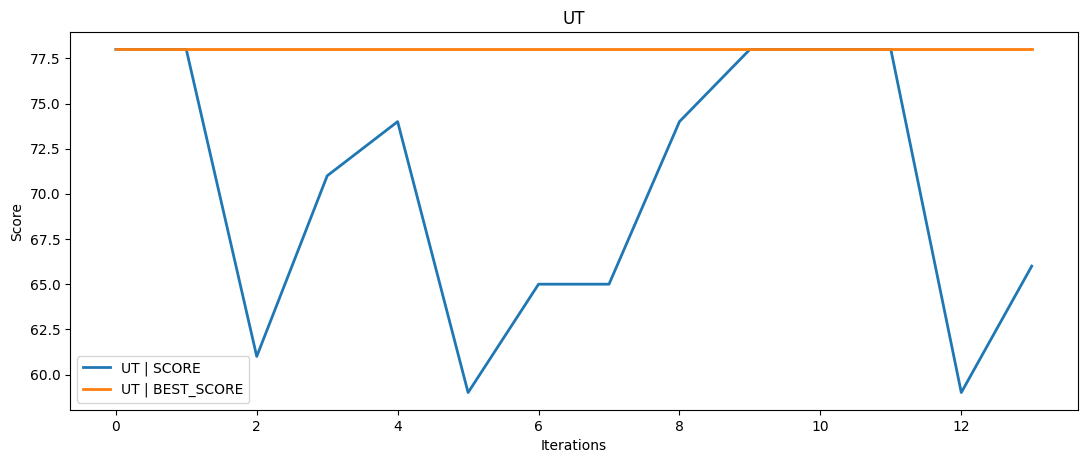

In [ ]:
# load the problem from the file
prob_sa_ut = Problem()
prob_sa_ut.load_data('data/z_knownsolution.txt')

#define the parameter for the SA algorithm
params_ut = {
    'temperature' : 100,
    'alpha': 0.7,
    'iterations': 15,
    'repetitions': 1,
    'step_size': 1,
    'schedule': slow_schedule,
    'log_id': 'UT'
}

#run the algorithm
ut_best,ut_best_eval = simulated_annealing(prob_sa_ut, params_ut)
print(f'SA, Rnd Init Solution, Scenario {params_ut["log_id"]}, Best Score: {ut_best_eval}')
print(f'Solution: {ut_best}')
Logger.plot_method_metrics(params_ut['log_id'],['SCORE','BEST_SCORE'])

**2. Actual Problem Analysis**

Data Loading:

In [ ]:
# load the problem from the file
# problem rd initialised with a random solution agreed upfront for benckmarking
prob_sa_rd = Problem()
prob_sa_rd.load_data('data/b_read_on.txt')
prob_sa_rd.init_solution = RAND_SOL_B

# problem ds initialised with the 'deterministic' solution
prob_sa_ds = Problem()
prob_sa_ds.load_data('data/b_read_on.txt')
prob_sa_ds.init_solution = prob_sa_ds.score_signup_solution() 

load completed
nr. of libraries: 100
average nr. of books: 1000
load completed
nr. of libraries: 100
average nr. of books: 1000


Calibration of algorithm's parameters taking into account:

* initial temperature
* desired cooling speed
* max. number of iterations
* estimated average difference between neighbors' evaluations (random walk)

In [ ]:
# go from solution to neighbor solution for 1000 times
# and calculate the average difference between neighbors' evaluations 
diff = []
sol = prob_sa_rd.random_solution()
for i in range(1,1000):
    neig = prob_sa_rd.neighbour_solution(sol, 10)
    eval_sol = prob_sa_rd.score_solution(sol)
    eval_neig = prob_sa_rd.score_solution(neig)
    diff.append(abs(eval_sol-eval_neig))
    sol = list(neig)

m_diff = (sum(diff)/(len(diff)))/1000
print(f'mean difference: {m_diff}')

mean difference: 90.6935935935936


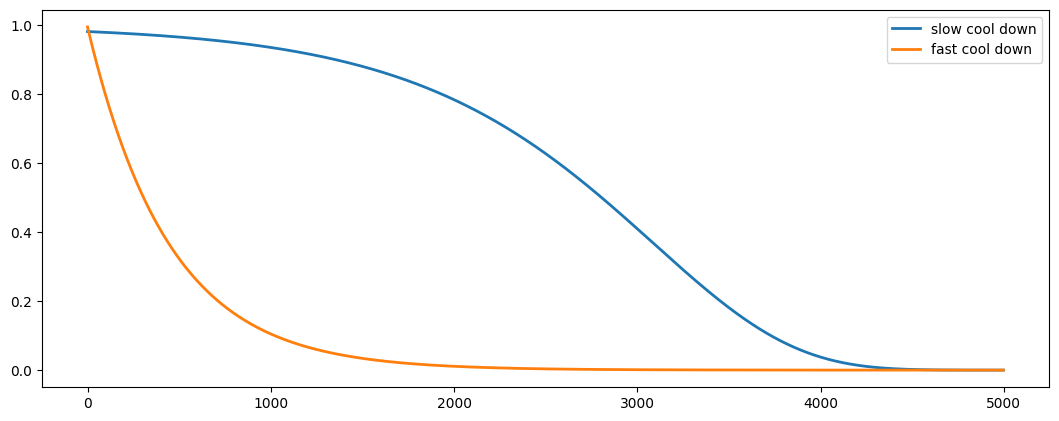

In [ ]:
# show resulting temp cooling / probabily of moving to worse solutions
c_params_slow = {
    'temperature' : 5000,
    'alpha' : 0.9987
}
c_params_fast = {
    'temperature' : 40000
}
c_iterations = 5000
c_avg_diff = - int(m_diff)   # calculated in the previous block
c_prob_slow = []
c_prob_fast = []

for i in range (1, c_iterations):
    c_prob_slow.append(np.exp(c_avg_diff/slow_schedule(i, c_params_slow)))
    c_prob_fast.append(np.exp(c_avg_diff/fast_schedule(i, c_params_fast)))

plt.figure(1, figsize = (13, 5), dpi = 100)
plt.plot(c_prob_slow, linewidth=2.0, label='slow cool down')
plt.plot(c_prob_fast, linewidth=2.0, label='fast cool down')
plt.legend()
plt.show()

Scenarios, i.e. sets of parameters analysed:

In [ ]:
#set parameters for scenario 1:
#s1: fast cool down
params_s1 = {
    'temperature' : 40000,
    'iterations': 5000,
    'repetitions': 10,
    'step_size': 30,
    'schedule': fast_schedule,
    'log_id': 'SAs1'
}

#s2: s1 <- change to show cool down
params_s2 = {
    'temperature' : 5000,
    'alpha': 0.998,
    'iterations': 5000,
    'repetitions': 10,
    'step_size': 30,
    'schedule': slow_schedule,
    'log_id': 'SAs2'
}

#s3: s2 <- increase neighbor distance 
params_s3 = {
    'temperature' : 5000,
    'alpha': 0.998,
    'iterations': 5000,
    'repetitions': 10,
    'step_size': 100,
    'schedule': slow_schedule,
    'log_id': 'SAs3'
}

Results of the Simulated Annealing algorithm run for the different scenarios above:

SA, Rnd Init Solution, Scenario SAs1, Best Score: 4710400.0


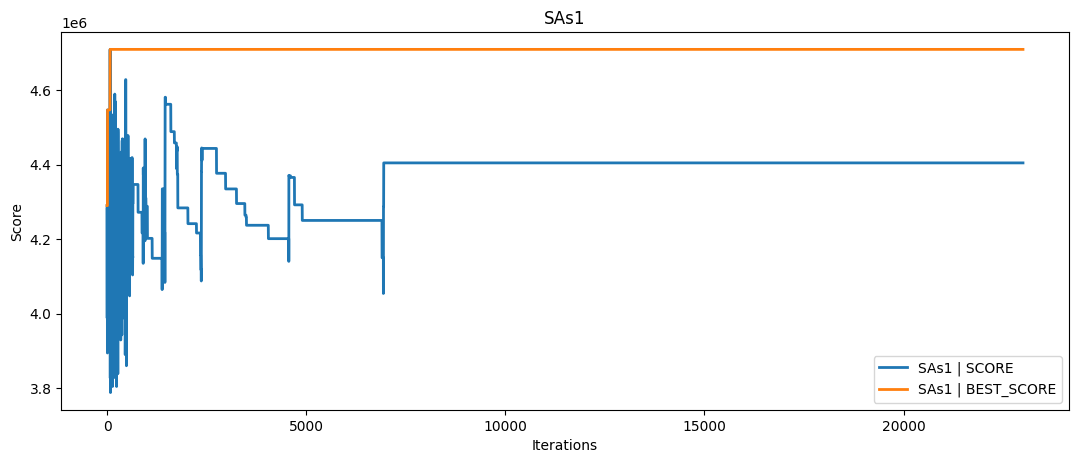

SA, Rnd Init Solution, Scenario SAs2, Best Score: 4786100.0


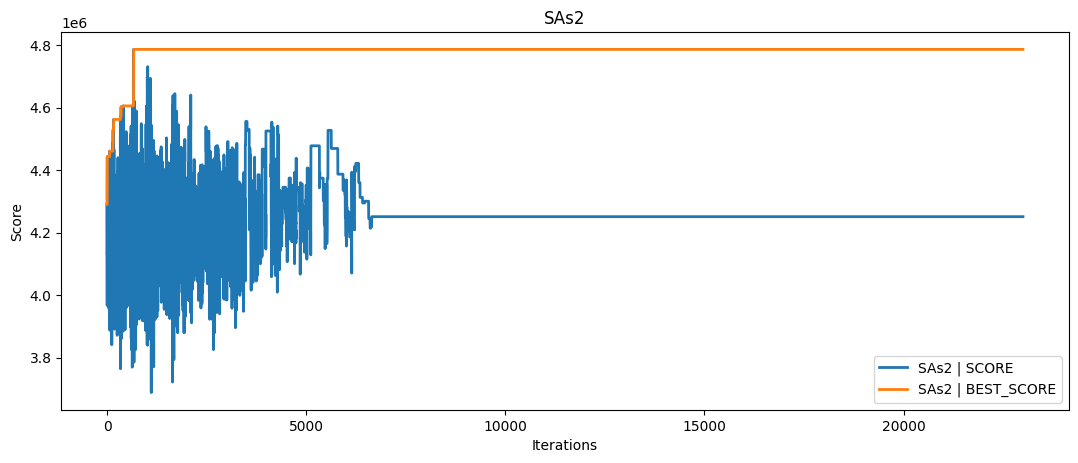

SA, Rnd Init Solution, Scenario SAs3, Best Score: 5350000.0


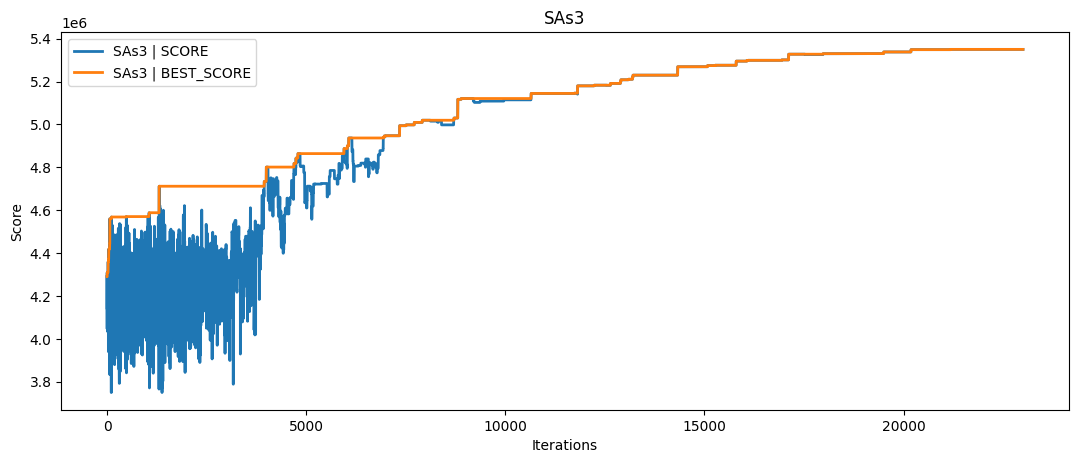

In [ ]:
#execute the search
scenarios = [params_s1,params_s2,params_s3]

# run scenarios for random solution

for scenario in scenarios:
    _,best_eval = simulated_annealing(prob_sa_rd, scenario)
    print(f'SA, Rnd Init Solution, Scenario {scenario["log_id"]}, Best Score: {best_eval}')
    Logger.plot_method_metrics(scenario['log_id'],['SCORE','BEST_SCORE'])

The scenario with best evalution above was combined with the 'deterministic' solution as the initial solution. Results below:

SA, Det Init Solution, Scenario SAs3, Best Score: 5822900.0


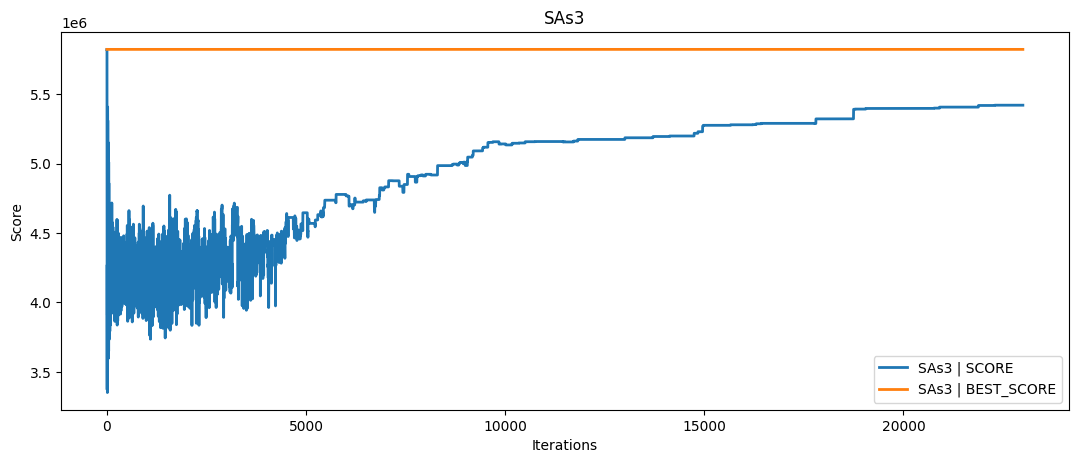

In [ ]:
#define the best scenario
best_scenario = params_s3

# run the algorithm
_,best_eval = simulated_annealing(prob_sa_ds, best_scenario)
print(f'SA, Det Init Solution, Scenario {best_scenario["log_id"]}, Best Score: {best_eval}')
Logger.plot_method_metrics(best_scenario['log_id'],['SCORE','BEST_SCORE'])

# Genetic Algorithm

In [ ]:
# genetic algorithm functions

# define initial population
def Population_Generator(data, nPopulation):

    population = []

    for i in range(nPopulation):

        chromosomes = data.random_solution()
        population.append(chromosomes)
        
    return population

# evaluate the population members
def Fitness_Function(data, population):

    # compute the score of the population members

    score = []
    for i in range(len(population)):
        
        fitness = data.score_solution(population[i])
        score.append(fitness)
    
    return score

# selection method
def Selection(data, selectionType, selectionRate, nParti, population):

    # select the best members of the current population for parents during reproduction

    from operator import itemgetter # find the maximum value in a tuple

    if selectionType == 'tournament': # tournament selection method

        nSelection = round(len(population) * selectionRate)
        tournSelection = []
        excludeIndex = []
        
        for i in range(nSelection): # choose randomly nSelection chromosomes from the population

            selectionIndex = random.choice(list(set([m for m in range(0, len(population))]) - set(excludeIndex))) # no repeated chromosomes will be chosen
            tournSelection.append(population[selectionIndex])
            excludeIndex.append(selectionIndex) # exlusion list to avoid repeated chromosomes

        selection = []
        selectionScore = []

        for i in range(nSelection): # compare the nSelection chromosomes, and choose the ones with the best score 

            scoreTourn = []
            excludeIndex = []
            
            for k in range(nParti):

                partiIndex = random.choice(list(set([m for m in range(0, nSelection)]) - set(excludeIndex))) # no repeated chromosomes will be choosed
                partiScore = data.score_solution(tournSelection[partiIndex]) # compute gene score
                scoreTourn.append((partiIndex, partiScore)) # tuple with the chromose index and correspondent score
                excludeIndex.append(partiIndex) # exlusion list to avoid repeated chromosomes in the same tournament
            
            winnerScore = max(scoreTourn, key = itemgetter(1))[0] # from the chromosomes enrolled in the tournament check the chromosome index with the maximum score
            winnerChrom = tournSelection[winnerScore] # tournament winner chromosome
            
            selection.append(winnerChrom) # append the winner chromosome to the selection list
            
        selection = [list(x) for x in {tuple(x) for x in selection}]
        
    return selection

# pair population and selected chromosomes
def Pair(population, selection):

    # pair the selected number of choromosomes with other population chromosomes (without repetition)

    pair = []
    excludeIndex = []
    i = 0

    while i != len(selection): # choose randomly chromosomes from the population to be pared with the selected chromosomes

        populationIndex = random.choice(list(set([m for m in range(0, len(population))]) - set(excludeIndex))) # no repeated chromosomes will be chosen
        populationPair = population[populationIndex]

        if populationPair != selection[i]: # if different it will be considered as a pair

            pair.append(populationPair)
            excludeIndex.append(populationIndex)
            i = i + 1

    return pair

# reproduction - crossover and mutation
def Modification(data, crossoverRate, mutationRate, parents1, parents2):
    
    # from the list of all the parents1 and all the parents2 perform the crossover recombination

    import random

    children = []

    for i in range(len(parents1)): 

        randomNum = random.random()

        if crossoverRate > randomNum: # perform crossover randomly or all the parents 

            parent1 = parents1[i]
            parent2 = parents2[i]

            child1 = parent1.copy()
            child2 = parent2.copy()

            child1ExcludeLib = []
            child2ExcludeLib = []

            crossIndex = random.choice(list(set([m for m in range(0, len(parent1)-1)])))
            
            # crossover over libraries
            for j in range(len(parent1)): # before crossover point child1 = parent1

                if j <= crossIndex:

                    child1[j] = parent1[j]
                    child1ExcludeLib.append(parent1[j][0])

                    child2[j] = parent2[j]
                    child2ExcludeLib.append(parent2[j][0])

            child1Step = crossIndex + 1
            child2Step = crossIndex + 1

            for k in range(len(parent1)): # after crossover point child1 = parent2 without repetition and following the same order

                if (parent2[k][0] in child1ExcludeLib) == False:

                    child1[child1Step] = parent2[k]
                    child1Step = child1Step + 1

                if (parent1[k][0] in child2ExcludeLib) == False:

                    child2[child2Step] = parent1[k]
                    child2Step = child2Step + 1

            if mutationRate > randomNum: # perform mutation for child1 and child2

                # rotate libraries
                libraryRotateIndex = random.choice(list(set([m for m in range(0, len(child1))])))
                
                child1 = data.rotate_books(child1, libraryRotateIndex, nr_rotations = 1)
                child2 = data.rotate_books(child2, libraryRotateIndex, nr_rotations = 1)

            children.append(child1)
            children.append(child2)

        else:

            children.append(parents1[i])
            children.append(parents2[i])

    return children

# generation
def Generation(population, score, modification):

    # generates the next offspring supported in the modified chromosomes (by crossover and mutation) and the best population chromosomes

    from operator import itemgetter

    nRecapPopulation = len(population) - len(modification)

    chrmoScore = []
    sortedChromArran = []
    offspring = []

    for i in range(len(population)):

        chrmoScore.append((population[i], score[i]))
    
    sortedChrom = sorted(chrmoScore, key = itemgetter(1), reverse = True)[:nRecapPopulation]
    
    for i in range(nRecapPopulation):

        sortedChromArran.append(sortedChrom[i][0])

    offspring = modification + sortedChromArran

    return offspring

# genetic algorithm main function
def geneticAlgorithm(filename, gaReps, parameters):

    # genetic algorithm implementation function

    # import data
    data = Problem()
    data.load_data(filename)

    # algorithm hyperparameters
    nPopulation = parameters['nPopulation']         # number of chromosomes (elements) in the population
    nGenerations = parameters['nGenerations']       # number if generations to iterate
    selectionType = parameters['selectionType']     # selection method to be used (tournament or roullete)
    selectionRate = parameters['selectionRate']     # determines the population parcel which will participate in the selection stage, range from 0 to 1
    nParti = parameters['nParti']                   # number of participants enrolled in the tournament
    crossoverRate = parameters['crossoverRate']     # determines whether crossover is performed or not, range from 0 to 1
    mutationRate = parameters['mutationRate']       # determines whether mutation is performed or not, range from 0 to 1
    log_id = parameters['log_id']

    # hyperparameters restrictions
    if (nPopulation * selectionRate) < nParti:

        sys.exit(f'Not allowed number of participants (nParti), since nPopulation x selectionRate ({int(nPopulation * selectionRate)}) is lower than nParti ({nParti}).\nChoose a nParti lower or equal to {int(nPopulation * selectionRate)}.')

    # log the method and its parameters
    Logger.log_method(log_id,parameters)
    Logger.log_time(log_id,'INIT')

    # iterate over nGenerations
    gaIter = []
    bestScoreIter = []

    for rep in range(gaReps):
        
        nGen = []
        bestGenScore = []
        holdBestGenScore = []
        
        print(f'\niteration = {rep+1}')

        for gen in range(nGenerations):

            if gen == 0: # generates initial population

                population = Population_Generator(data, nPopulation)

            score = Fitness_Function(data, population)

            nGen.append(gen)
            bestGenScore.append(max(score))
            Logger.log_method_metric(log_id, SCORE = max(score))

            if bestGenScore[gen] > max(holdBestGenScore, default = 0):

                holdBestGenScore.append(bestGenScore[gen])
                Logger.log_method_metric(log_id, BEST_SCORE = bestGenScore[gen])

            else:

                holdBestGenScore.append(max(holdBestGenScore))
                Logger.log_method_metric(log_id, BEST_SCORE = max(holdBestGenScore))

            print(f'\rprogress = {round((gen/(nGenerations-1))*100, 1)}%', end='')

            # selection
            selection = Selection(data, selectionType, selectionRate, nParti, population)

            # pair
            pair = Pair(population, selection)
            
            # reproduction - crossover and mutation
            parents1 = selection
            parents2 = pair 
            reproduction = Modification(data, crossoverRate, mutationRate, parents1, parents2)

            # generation
            population = Generation(population, score, reproduction)

        Logger.log_time(log_id,'END')

        bestScoreIter.append(max(bestGenScore))
        
        # print results
        print(f'\nbest score over iterations = {bestScoreIter}')
        print(f'best score average = {round(statistics.mean(bestScoreIter), 2)}')


## GA Exploratory Analysis

In [ ]:
# three different scenarios focused in the reproduction stage (crossover and mutation) are going to be explored:
# 1. low diversity scenario (low crossover and mutations rates)
# 2. medium diversity scenario (medium crossover and mutations rates)
# 3. high diversity scenario (high crossover and mutation rates)
# 4. medium diversity scenario - extended implementation to assure convergence

# 1. low diversity scenario
lowDiversity = {
    'nPopulation' : 100,
    'nGenerations': 100,
    'selectionType': 'tournament',
    'selectionRate': 0.5,
    'nParti': 20,
    'crossoverRate': 0.2,
    'mutationRate': 0.1,
    'log_id': 'ga ld'
}

# 2. medium diversity scenario
mediumDiversity = {
    'nPopulation' : 100,
    'nGenerations': 100,
    'selectionType': 'tournament',
    'selectionRate': 0.5,
    'nParti': 20,
    'crossoverRate': 0.5,
    'mutationRate': 0.4,
    'log_id': 'ga md'
}

# 3. high diversity scenario
highDiversity = {
    'nPopulation' : 100,
    'nGenerations': 100,
    'selectionType': 'tournament',
    'selectionRate': 0.5,
    'nParti': 20,
    'crossoverRate': 0.9,
    'mutationRate': 0.8,
    'log_id': 'ga hd'
}

# 4. medium diversity scenario - extended
mediumDiversityExtended = {
    'nPopulation' : 100,
    'nGenerations': 300,
    'selectionType': 'tournament',
    'selectionRate': 0.5,
    'nParti': 20,
    'crossoverRate': 0.5,
    'mutationRate': 0.4,
    'log_id': 'ga md ex'
}

load completed
nr. of libraries: 100
average nr. of books: 1000

iteration = 1
progress = 100.0%
best score over iterations = [4784200]
best score average = 4784200


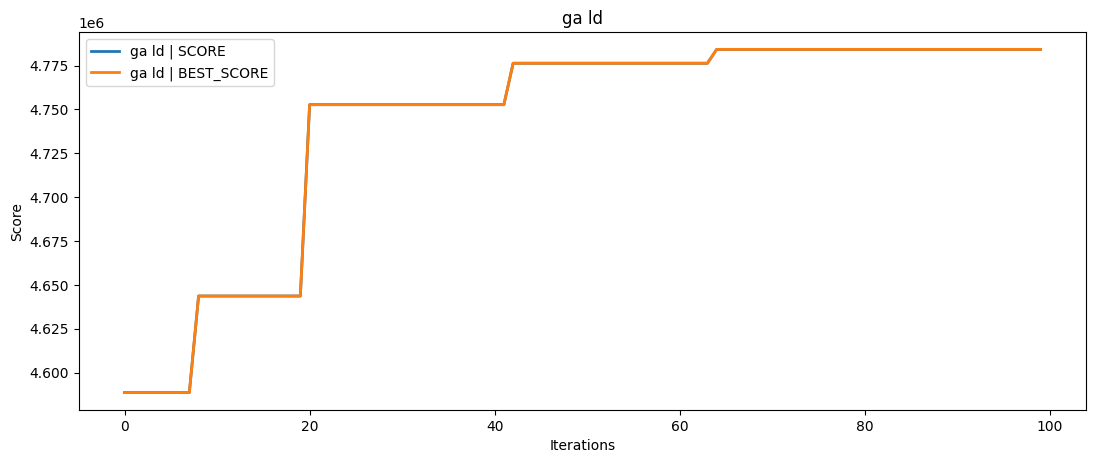

METHOD: ga ld
	PARAMETERS: {'nPopulation': 100, 'nGenerations': 100, 'selectionType': 'tournament', 'selectionRate': 0.5, 'nParti': 20, 'crossoverRate': 0.2, 'mutationRate': 0.1, 'log_id': 'ga ld'}
	METRICS:
		EXEC_TIME: 1358
		SCORE: [4588700, 4588700, 4588700, 4588700, 4588700, 4588700, 4588700, 4588700, 4643700, 4643700, 4643700, 4643700, 4643700, 4643700, 4643700, 4643700, 4643700, 4643700, 4643700, 4643700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4752700, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4776300, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200, 4784200,

In [ ]:
# 1. low diversity scenario
geneticAlgorithm(filename = 'data/b_read_on.txt', gaReps = 1, parameters = lowDiversity)
Logger.plot_method_metrics('ga ld',['SCORE','BEST_SCORE'])
Logger.print_method_log('ga ld')

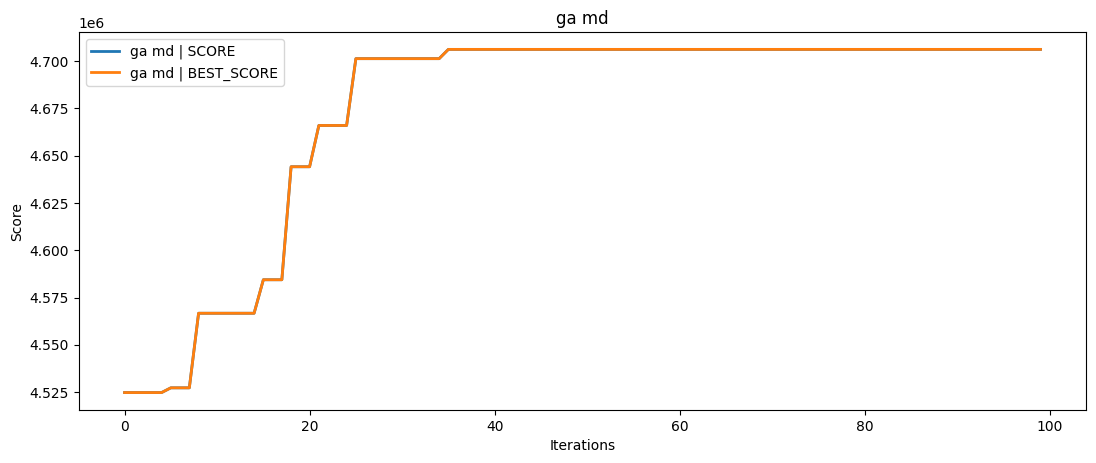

METHOD: ga md
	PARAMETERS: {'nPopulation': 100, 'nGenerations': 100, 'selectionType': 'tournament', 'selectionRate': 0.5, 'nParti': 20, 'crossoverRate': 0.5, 'mutationRate': 0.4, 'log_id': 'ga md'}
	METRICS:
		EXEC_TIME: 1346
		SCORE: [4524800, 4524800, 4524800, 4524800, 4524800, 4527300, 4527300, 4527300, 4566700, 4566700, 4566700, 4566700, 4566700, 4566700, 4566700, 4584400, 4584400, 4584400, 4644100, 4644100, 4644100, 4665900, 4665900, 4665900, 4665900, 4701200, 4701200, 4701200, 4701200, 4701200, 4701200, 4701200, 4701200, 4701200, 4701200, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100, 4706100,

In [ ]:
# 2. medium diversity scenario
geneticAlgorithm(filename = 'data/b_read_on.txt', gaReps = 1, parameters = mediumDiversity)
Logger.plot_method_metrics('ga md',['SCORE','BEST_SCORE'])
Logger.print_method_log('ga md')

load completed
nr. of libraries: 100
average nr. of books: 1000

iteration = 1
progress = 100.0%
best score over iterations = [5001000]
best score average = 5001000


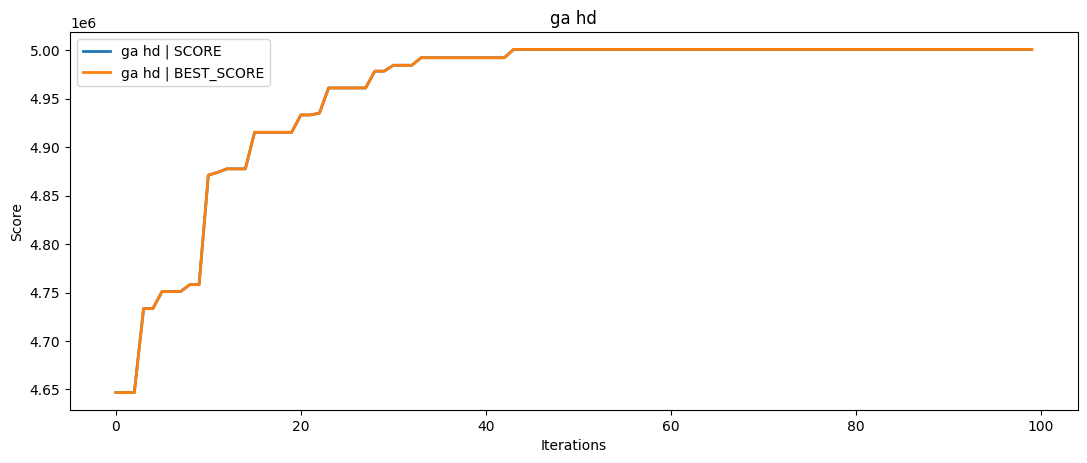

METHOD: ga hd
	PARAMETERS: {'nPopulation': 100, 'nGenerations': 100, 'selectionType': 'tournament', 'selectionRate': 0.5, 'nParti': 20, 'crossoverRate': 0.9, 'mutationRate': 0.8, 'log_id': 'ga hd'}
	METRICS:
		EXEC_TIME: 1459
		SCORE: [4646800, 4646800, 4646800, 4733500, 4733500, 4751100, 4751100, 4751100, 4758200, 4758200, 4871200, 4874000, 4877700, 4877700, 4877700, 4915400, 4915400, 4915400, 4915400, 4915400, 4933300, 4933300, 4935100, 4961200, 4961200, 4961200, 4961200, 4961200, 4978500, 4978500, 4984600, 4984600, 4984600, 4992400, 4992400, 4992400, 4992400, 4992400, 4992400, 4992400, 4992400, 4992400, 4992400, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000, 5001000,

In [ ]:
# 3. high diversity scenario
geneticAlgorithm(filename = 'data/b_read_on.txt', gaReps = 1, parameters = highDiversity)
Logger.plot_method_metrics('ga hd',['SCORE','BEST_SCORE'])
Logger.print_method_log('ga hd')

load completed
nr. of libraries: 100
average nr. of books: 1000

iteration = 1
progress = 100.0%
best score over iterations = [4950600]
best score average = 4950600


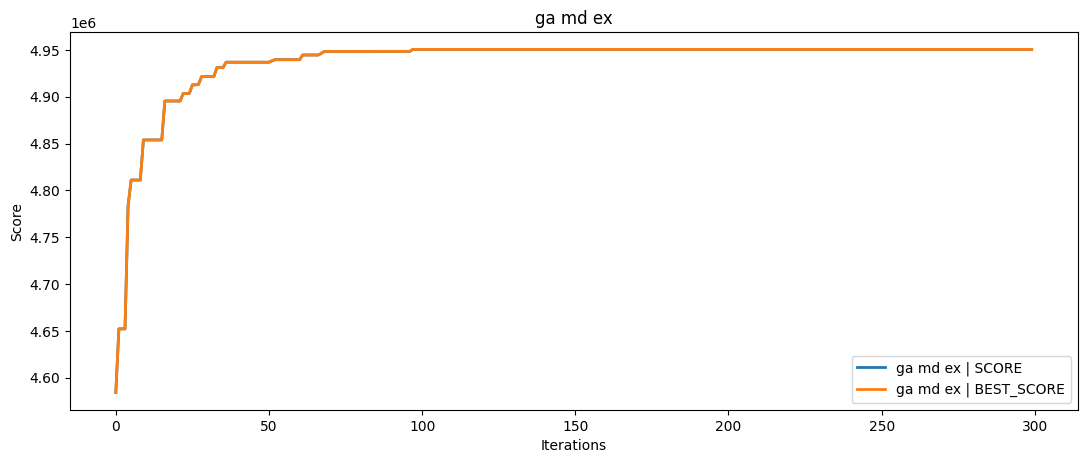

METHOD: ga md ex
	PARAMETERS: {'nPopulation': 100, 'nGenerations': 300, 'selectionType': 'tournament', 'selectionRate': 0.5, 'nParti': 20, 'crossoverRate': 0.5, 'mutationRate': 0.4, 'log_id': 'ga md ex'}
	METRICS:
		EXEC_TIME: 4357
		SCORE: [4584200, 4652200, 4652200, 4652200, 4783500, 4811100, 4811100, 4811100, 4811100, 4853900, 4853900, 4853900, 4853900, 4853900, 4853900, 4853900, 4895500, 4895500, 4895500, 4895500, 4895500, 4895500, 4903600, 4903600, 4903600, 4912700, 4912700, 4913300, 4921500, 4921500, 4921500, 4921500, 4921500, 4931100, 4931100, 4931100, 4936900, 4936900, 4936900, 4936900, 4936900, 4936900, 4936900, 4936900, 4936900, 4936900, 4936900, 4936900, 4936900, 4936900, 4936900, 4938400, 4939600, 4939600, 4939600, 4939600, 4939600, 4939600, 4939600, 4939600, 4939600, 4944600, 4944600, 4944600, 4944600, 4944600, 4944600, 4946100, 4948400, 4948400, 4948400, 4948400, 4948400, 4948400, 4948400, 4948400, 4948400, 4948400, 4948400, 4948400, 4948400, 4948400, 4948400, 4948400, 49

In [ ]:
# 4. medium diversity scenario - extended
geneticAlgorithm(filename = 'data/b_read_on.txt', gaReps = 1, parameters = mediumDiversityExtended)
Logger.plot_method_metrics('ga md ex',['SCORE','BEST_SCORE'])
Logger.print_method_log('ga md ex')

# Tabu Search

Implementation of the tabu search algorithm. 

The solutions are lists of tuples with (Library_id, Book_id) with the index in the list representing the order in which the library sends books for scanning. 

In each iteration the algorithm creates a neighbourhood for the current best candidate which is composed of permutations in the libraries order or in one library's book order to generate new candidate solutions. Next, a local search is conducted using best accept approach to select the next best candidate solution.

Each new solution, consisting of pairs of library/book tuples that were permutated and the corresponding indices in the solution list, is stored in a tabu list.

New candidate solutions will only be used if they do not exist in the tabu list. 

In [ ]:
# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                NEIGHBOUR GENERATOR                                      #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


def generate_neighbour_TS(problem, solution, paramsLS):
  

    """
    ---------------------
    GENERATE NEW NEIGHBOUR
    ---------------------
    
    Generates a neighbour solution based on an existent solution.
    A neighbour solution is one where libraries are exchange pairwise at a maximum distance dist between dist_L_min and dist_L_max
    For example, if dist_L_min = 3 and dist_L_max = 5, then library in position 10 can be exchanged with the ones in positions  5, 6, 7, 13, 14, or 15.
    
    Another neighbour solution is where the starting book of a library does not differ more than dist_B.
    For example, if dist_B = 2 and a library is starting a position 3, a neighbour can start at position 1, 2, 4 or 5 


    --- input ---
    problem              | (class)   : Problem class with methods and all elements of the problem
    solution             | (list)    : solution to the problem
    params               | (list)    : list of parameters to use in LS and sub-functions
      param: nlibs       | (integer) : number of libraries in the problem
      param: dist_L_min  | (integer) : minimum distance between libraries in the neighborhood used in the Local Search
      param: dist_L_max  | (integer) : maximum distance between libraries in the neighborhood used in the Local Search
      param: dist_B      | (integer) : maximum distance between books in the neighborhood used in the Local Search
      param: LBbal       | (integer) : treshold to decide if neighbour is resultant from permutation of libraries or books

    --- output ---
    new_solutionL        | (list)    : new solution with permutations in the library sequence
    new_solutionB        | (list)    : new solution with permutations in the books sequence
    tabu_nodes           | (tuple)   : tuple with the nodes (library, book) that were permutated between the given solution and the best neighbour found
    tabu_idx             | (tuple)   : tuple with the indices of the nodes that were permutated
    """

    # Obtain necessary parameters

    nlibs        = paramsLS['nr_libs']
    #avg_nr_book = paramsLS['avg_nr_book']
    #max_iter    = paramsLS['max_iter']
    #max_iter_LS = paramsLS['max_iter_LS']
    dist_L_min  = paramsLS['dist_L_min']
    dist_L_max  = paramsLS['dist_L_max']
    dist_B      = paramsLS['dist_B']
    #tenure      = paramsLS['tenure']
    LBbal       = paramsLS['LBbal']
    #log_name    = paramsLS['log_name']


    def permutate_L(idxL1):

        dist = rnd.randint(dist_L_min,dist_L_max)                        # the distance between libraries to use
        
        idxL2 = idxL1 + (1 if rnd.randint(0,1) else -1) * dist           # the new position can be +/- dist from the original one

        if idxL2 <0 or idxL2 > nlibs - 1:                                # if the new book number is outside the prescribed range, it centers the result
            idxL2 = (idxL2 + nlibs) % nlibs                              # if it is outside the range adds the number of books and gets the modulo

        new_solutionL = copy.deepcopy(solution)                          # makes a copy of the current solution
        L_aux = new_solutionL[idxL2]                                     # copies the original library tuple to the an auxiliar variable
        new_solutionL[idxL2] = new_solutionL[idxL1]                      # copies the second library for the position of the first
        new_solutionL[idxL1] = L_aux                                     # copies the original library to the position of the second

        
        tabu_nodes = (new_solutionL[idxL2], new_solutionL[idxL1])
        tabu_idx = (idxL1, idxL2)
        
        
        return new_solutionL, tabu_nodes, tabu_idx
    
    def permutate_B(idxL1):


        new_solutionB = copy.deepcopy(solution)                         # copies the previous solution to a new variable
        old_lib, old_book = new_solutionB[idxL1]                        # book in the current solution to be substituted

        nbooks = len(problem.libraries[old_lib].books)                  # number of books in the library


        deltaB = max(int(dist_B * nbooks),1)

        dist = rnd.randint(1, deltaB)                                   # chooses a distance between 1 and deltaB
        new_book = old_book + dist                                      # the new position can be +/- dist from the original one
     
        if new_book > nbooks:                                           # if the new book number is outside the prescribed range, it centers the result
            new_book = new_book % nbooks + 1                            # if it is outside the range adds the number of books and gets the modulo
        
        if new_book == 0:                                               # the modulo function returns 0...nbooks-1. This changes the scale to 1...nbooks
          new_book = nbooks
 
        new_solutionB[idxL1] = (old_lib, new_book)                      # substitutes the old tuple by the new one.

        tabu_nodes = ((old_lib, old_book) , (old_lib,new_book))         # builds the tabu nodes
        tabu_idx = (idxL1, idxL1)                                       # builds the tabu indices
        
        
        return new_solutionB, tabu_nodes, tabu_idx

    idxL1 = rnd.randrange(0, nlibs)                                    # generates a random index for the library id which will be pertutated with another or its starting book

    # The new solution is randomly selected from a permutation of L or B
    # This threshold LBbal defines which permutation to take. If above LBbal, then it is permutate_B, else permutate_L
    if rnd.uniform(0,1) < LBbal:
        return permutate_L(idxL1)
    else:
        return permutate_B(idxL1)

# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                      LOCAL SEARCH                                       #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


# Adapted from: https://github.com/edgarsmdn/TS

def LS(problem_TS, solution, paramsLS, df_tabuList, iteration_LS, tabus_found):
    '''
    ---------------------
    LOCAL SEARCH ALGORITHM
    ---------------------

    --- input ---
    problem_TS           | (class)     : Problem class with methods and all elements of the problem
    solution             | (list)      : solution to the problem
    params               | (list)      : list of parameters to use in LS and sub-functions
      param: max_iter_LS | (integer)   : maximum number of iterations for the Local Search
      param: log_name    | (string)    : identifier or results inside the logger
    df_tabuList          | (dataframe) : tabu list
    iteration_LS         | (integer)   : iteration of LS 
    tabus_found          | (integer)   : number of tabus found so far in LS 

    --- output ---
    best_value           | (integer)   : value of the candidate solution obtained by LS
    best_solution        | (list)      : candidate solution obtained by LS
    nodes                | (tuple)     : tuple with the nodes (library, book) that were permutated between the given solution and the best neighbour found
    idx                  | (tuple)     : tuple with the indices of the nodes that were permutated
    iteration_LS         | (integer)   : iteration of LS 
    tabus_found          | (integer)   : number of tabus found so far in LS 
    '''

    # Obtain necessary parameters

    #nr_libs     = paramsLS['nr_libs']
    #avg_nr_book = paramsLS['avg_nr_book']
    #max_iter    = paramsLS['max_iter']
    max_iter_LS = paramsLS['max_iter_LS']
    #dist_L_min  = paramsLS['dist_L_min']
    #dist_L_max  = paramsLS['dist_L_max']
    #dist_B      = paramsLS['dist_B']
    #tenure      = paramsLS['tenure']
    #LBbal       = paramsLS['LBbal']
    log_name    = paramsLS['log_name']

    # ----------------------------------------------
    best_solution = solution
    best_value = problem_TS.score_solution(solution)


    # Iteration Loop
    for i_iter in range(max_iter_LS):
        # Tries random values in the vicinity of the best position so far

        # Generates a random neighbour
        p_trial, nodes, idx = generate_neighbour_TS(problem_TS, solution, paramsLS)

        # Function value of current solution
        trial_value = problem_TS.score_solution(p_trial)

        # Log current score
        Logger.log_method_metric(log_name, SCORE = trial_value)

        # creates the tabus tuple to verify if exists in the tabu list already
        tabus = (nodes, idx)

        # Verifies if the tabus exist in the tabuList      
        if df_tabuList.isin([tabus]).tabus.any():
            
            # updates counter on tabus found
            tabus_found += 1
            
            # If the solution belongs to the tabu list, does nothing
            continue

        
        if trial_value > best_value:
            # If trial value is better than best value, it gets substituted
            best_solution = p_trial
            best_value  = trial_value
                
            # Found a new best value. Logs the iteration where it was found
            Logger.log_method_metric(log_name, override = True, BEST_SCORE_ITER = iteration_LS)
        
        # Logs the best value at the end of this iteration
        Logger.log_method_metric(log_name, BEST_SCORE = best_value)
       

        iteration_LS +=1
        
    return best_value, best_solution, nodes, idx, iteration_LS, tabus_found




# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                       TABU SEARCH                                       #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


# Adapted from https://github.com/edgarsmdn/TS

#import pandas as pd
#import numpy as np
import random as rnd

def TS(problem_TS, s_init, params):
    '''
    ------------------------------
    TABU SEARCH ALGORITHM
    ------------------------------

    --- input ---
    problem_TS           | (class)   : Problem class with methods and all elements of the problem
    s_init               | (list)    : initial solution to the problem
    params               | (list)    : list of parameters to use in TS and sub-functions
      param: max_iter    | (integer) : maximum number of iterations for Tabu Search
      param: tenure      | (integer) : maximum number of iterations a solution is kept in the tabu list
      param: log_name    | (string)  : identifier or results inside the logger
        
    --- output ---
    Optimum: (class) Results with:
        Optimum.f           | (integer) : the best value of the funtion found in the optimization
        Optimum.sBest       | (list)    : the best solution returned from TS
        Optimum.tabus_found | (integer) : number of tabus that were found in the tabuList while searching for neighbours
    '''
    
    # Obtain parameters that are relevant to the TS algorithm
    nr_libs     = params['nr_libs']
    # avg_nr_book = params['avg_nr_book']
    max_iter    = params['max_iter']
    # max_iter_LS = params['max_iter_LS']
    dist_L_min  = params['dist_L_min']
    dist_L_max  = params['dist_L_max']
    # dist_B      = params['dist_B']
    tenure      = params['tenure']
    LBbal       = params['LBbal']
    adaptative  = params['adaptative']
    log_name    = params['log_name']

  
 
    # log the method and its parameters
    Logger.log_method(log_name,params)
    Logger.log_time(log_name,'INIT')

       
    # copies params to paramsLS
    paramsLS = copy.deepcopy(params)

    # Initializations
    bestCandidate    = s_init                                                   # candidate to best solution
    bestCandidatef   = problem_TS.score_solution(bestCandidate)                 # value of candidate to best solution  
    sBest            = bestCandidate                                            # best solution found so far
    sBestf           = bestCandidatef                                           # value of best solution found so far




    if adaptative:

      # constants for the decay functions
      base = 10
      # decayConst (base, fa, fi, fn, i, n)
      constLmin = decayConst (base, 1, dist_L_min, max(2, int(0.1 * dist_L_min)), 1, max_iter//2)
      constLmax = decayConst (base, 2, dist_L_max, max(3, int(0.1 * dist_L_max)),  1, max_iter//2)
      constLBbal = decayConst (base, 0, LBbal, 0.1 * LBbal, 1, max_iter)

      # array with the last values to the solution
      lastf = np.full(int(0.1 * max_iter), sBestf)

      # tolerance for stopping criterion
      tolerance = 1E-6

    iteration        = 1                                                        # iteration of TS algorithm (outer loop)
    iteration_LS     = 1                                                        # iteration of LS algorithm (inner loop) to search the neighbourhood
    tabus_found      = 0                                                        # number of solutions tested that were already in the tabuList

    # Creates empty tabu list    
    df_tabuList = pd.DataFrame(columns = ['tabus', 'tabu_nodes', 'penalty'])
        
    maxTabuList = len(df_tabuList)
 
    # Initializes stopping criterion
    stopCriterion = True

    # Iteration Loop
    while stopCriterion:
        
        
        #decayFunction(base, constant, fa, fi, i, iter)
        # In the adaptative mode the algorithm uses an exponential function to adapt some hyper-parameters as iterations progress
        if adaptative:
          dist_L_min_LS = int(decayFunction(base, constLmin, 1, dist_L_min, 1, iteration))
          dist_L_max_LS = int(decayFunction(base, constLmax, 2, dist_L_max, 1, iteration))
          LBbal_LS = decayFunction(base, constLBbal, 1, LBbal, 1, iteration)

          paramsLS['dist_L_min'] = dist_L_min_LS
          paramsLS['dist_L_max'] = dist_L_max_LS
          paramsLS['LBbal'] = LBbal_LS

        # Searches the neighbourhood of the best candidate for new solutions
        bestCandidatef, bestCandidate, nodes, idx, iteration_LS, ntabus_found = LS(problem_TS, bestCandidate, paramsLS, df_tabuList, iteration_LS, tabus_found)

        # if the nodes already exist in the tabuList it resets the tenure of all tabus which have this pair of nodes
        # this is an ascension criterion whereas an already visited combination of nodes is allowed so long they improve the solution
        if df_tabuList.isin([nodes]).tabu_nodes.any():

            # the bestCandidate uses a pair of nodes that exist in the tabuList, thus we must reset penalty = tenure
            df_tabuList.loc[df_tabuList.isin([nodes]).tabu_nodes,'penalty'] = tenure

        # creates the tabus tuple with the pair of nodes and correspondent indices to insert in the tabuList
        tabus = (nodes, idx)

        # In principle, the bestCandidate from LS is not in the tabuList
        # But it might occur that the LS will result in the original solution, in which case, the solution belongs to the tabuList already
        checktabus = df_tabuList.isin([tabus]).tabus.any()

        if not checktabus:
            # if the tabus were not in the tabu lists, adds them
            dict = {'tabu': tabus, 'tabu_nodes': nodes, 'penalty': tenure}                                 
            df_row = pd.DataFrame([dict])
                    
            df_tabuList = pd.concat([df_tabuList, df_row], ignore_index=True)
            
            
            # Inverse of the tabus
            # Here I opted to speed up the process by inserting the inverted position of the tabus in the tabusList
            # It will use the double of the memory, but it should run faster. I hope ;-)
            nodes_inv = (nodes[1], nodes[0])
            tabus_inv = ((nodes[1], nodes[0]),(idx[1], idx[0]))
            dict = {'tabu': tabus_inv, 'tabu_nodes': nodes_inv, 'penalty': tenure}                                 
            df_row = pd.DataFrame([dict])
                    
            df_tabuList = pd.concat([df_tabuList, df_row], ignore_index=True)
                
            
        # if the candidate solution is the best found, updates the sBest and sBestf
        if bestCandidatef > sBestf:
            sBest = bestCandidate
            sBestf = bestCandidatef

        # Updates the tabulist size    
        if len(df_tabuList) > maxTabuList:
            maxTabuList = len(df_tabuList)        


        # reduces the penalty of existing elements of the tabu list
        df_tabuList['penalty'] = df_tabuList['penalty'] - 1
        df_tabuList=df_tabuList[df_tabuList['penalty'] >= 0]

        # ends the while updating the iteration counter
        iteration += 1
        
        if adaptative:
          lastf = np.append(lastf, sBestf)                                                                               # appends the latest value to the list
          dlastf = np.diff(lastf, 1, 0)                                                                                  # array with the differences between elements of lastf
          
          # Stopping criterion is either the # iterations or a decreasing change in the function value
          if iteration < int(0.1 * max_iter):
            stopCriterion = True
          else:
            stopCriterion = iteration < max_iter and  np.std(dlastf) > tolerance * np.average(dlastf)                    # Stopping criterion 
          
          lastf = np.delete(lastf, 0, 0)                                                                                 # Deletes the first element of the array
        else:
          stopCriterion = iteration < max_iter

    # Logs the number of tabus found during the search
    Logger.log_method_metric(log_name, override = True, TABUS_FOUND = tabus_found)

    Logger.log_method_metric(log_name, override = True, MAX_TABULIST = maxTabuList)

    # Log end of exectution
    Logger.log_time(log_name,'END')
    
    # Gather results
    class Optimum:
        pass    

    Optimum.sBestf           = sBestf
    Optimum.sBest            = sBest
    Optimum.tabus_found      = tabus_found

    return Optimum
    

## TS - Exponential decay function

In the adpative mode the hyper parameters of the TS algorithm vary exponentially from the value at the initial iteration till a pre-defined value at a prescribed iteration.

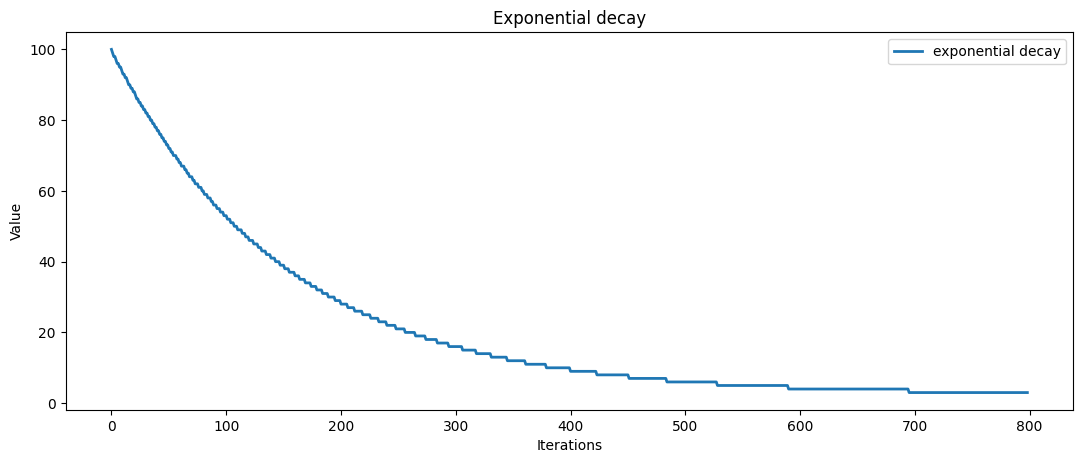

In [ ]:
# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                             EXPONENTIAL DECAY FUNCTION                                  #
#                                                                                         #
# ----------------------------------------------------------------------------------------#

"""
base - base of the exponential decay
i - start iteration
n - end iteration
fi - function value at i
fn - function value at j
fa = function value at infinity (assymptotic value)


fn = fa + dfn => dfn = fn - fa 
fi = fa + dfi => dfi = fi - fa


dfn = dfi * b^(c * (n - i)) 
dfn/dfi = b^(c * (jn-i))
log_b(dfn/dfi) = c * (n -i)
log_b(dfn) - log_base(dfi) = c * (n -i)
c = (log_b(dfn) - log_b(dfi)) / (n - i)

c = (log_b(fn - fa) - log_b(fi - fa)) / (n - i)

"""

def decayConst (b, fa, fi, fn, i, n):
  return (math.log(abs(fn - fa), b) - math.log(abs(fi - fa), b)) / (n - i)


def decayFunction(b, c, fa, fi, i, iter):
    return fa + (fi - fa) * pow(b, c * (iter - i)) 


# Example for the values of dist_L_max of file b

nr_libs = 100

base = 10
fi = int(1.0 * nr_libs)
fn = int(0.1 * fi)
fa = 3
i = 1
n = 800

constant = decayConst (base, fa, fi, fn, i, n//2)
   
arr = [int(decayFunction(base, constant, fa, fi, i, iter)) for iter in range(i, n)]

plt.figure(1, figsize = (13, 5), dpi = 100)
plt.plot(arr, linewidth=2.0, label = 'exponential decay')
plt.title('Exponential decay')
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.legend()
plt.show()

## TS - Plot function

This plot function calls the TS algorithm and plots the results for two different situations:
1. Plotting a single computation, i.e. a set of hyper-parameters for a given initial solution.
2. Plotting the results for a common initial solution, when one of the hyper-parameters changes.

In [ ]:
# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                          plotTS                                         #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


def plotTS(problem_TS, p_init, params0, metrics, dict_params = None):

    # Deterministic solutions scores
    score_signup_value = df_files[df_files.file == file[0]].iloc[0]['score/signup']
    signup_value = df_files[df_files.file == file[0]].iloc[0]['signup']

    dict_consts = {'Det. sol. score/signup':score_signup_value, 'Det. sol. 1/signup': signup_value}

    if dict_params == None:

      # name to show in the logger
      log_name = params0['log_name']
      
      # copies params to a local variable
      params = copy.deepcopy(params0)

      # computes the solution
      Optimum = TS(problem_TS, p_init, params)
      
      # prints the results
      print(f'Best value: {Optimum.sBestf}')
      Logger.print_method_log(log_name)

      # plots the results
      Logger.plot_method_metrics(log_name, metrics, dict_consts, log_name)

    else: 

      # loops over all 
      for parameter in dict_params:

        list_log_name = []
        # name to show in the logger
        log_name_ = params0['log_name']
        log_name_ = log_name_ + ' | ' + parameter

        list_log_name = []

        for param in dict_params[parameter]:
          
          # name to show in the logger
          log_name = log_name_ + ' = ' + str(param)
          
          # adds the log_name to the list of runs made
          list_log_name.append(log_name)

          # copies params to a local variable
          params = copy.deepcopy(params0)

          params['log_name'] = log_name
          params[parameter] = param

          # computes the solution
          Optimum = TS(problem_TS, p_init, params)

          # prints the results
          print(f'Best value: {Optimum.sBestf}')
          Logger.print_method_log(log_name)

        
        plt_title = log_name_
        # plots the results
        Logger.plot_method_metrics(list_log_name, metrics, dict_consts, plt_title)
    return Optimum

## TS Exploratory Analysis

Exploratory analysis of the TS algorithm. First with a unit test, which can be solved by hand, and then using file b.

### TS - Exploratory analysis | unit test

filename: data/z_knownsolution.txt
load completed
nr. of libraries: 4
average nr. of books: 3
Best value: 78
METHOD: TS | file z unit test
	PARAMETERS: {'nr_libs': 4, 'avg_nr_book': 3, 'max_iter': 5, 'max_iter_LS': 25, 'dist_L_min': 1, 'dist_L_max': 2, 'dist_B': 0.5, 'tenure': 7, 'LBbal': 0.5, 'adaptative': False, 'log_name': 'TS | file z unit test'}
	METRICS:
		EXEC_TIME: 0
		SCORE: [71, 76, 61, 71, 61, 65, 71, 71, 71, 61, 71, 76, 75, 71, 71, 71, 78, 65, 71, 61, 65, 76, 71, 71, 65, 78, 78, 78, 65, 76, 78, 65, 78, 78, 78, 78, 78, 78, 61, 61, 61, 78, 61, 78, 78, 78, 75, 78, 78, 78, 65, 61, 75, 75, 78, 61, 78, 78, 78, 78, 78, 75, 76, 78, 78, 78, 78, 78, 71, 78, 76, 78, 78, 75, 78, 78, 78, 78, 78, 78, 78, 71, 78, 78, 76, 61, 65, 78, 61, 78, 71, 76, 78, 78, 75, 61, 76, 78, 78, 75]
		BEST_SCORE: [71, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 7

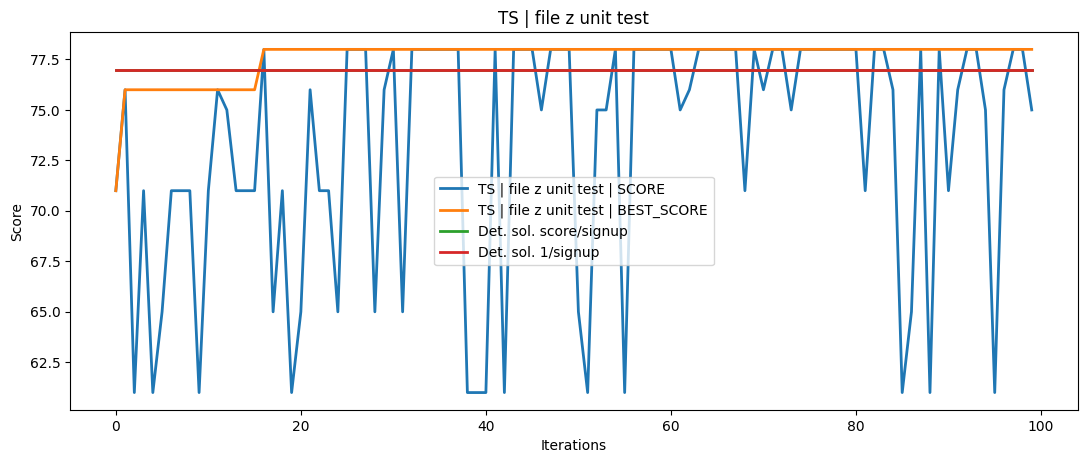

Solution: [(3, 1), (1, 2), (2, 3), (0, 2)]


In [ ]:
# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                         Unit Test                                       #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


files = ['z_knownsolution']
path_data = 'data/'


for file in files:

    # path to the file
    filename = path_data + file + '.txt'

    # prints the headed while we wait for the solution
    str_header = f'filename: {filename}'                                        
    print(str_header)

    # Name for logger
    log_name = 'TS | file ' + file[0] 


# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                 Initial solution setup                                  #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


    # initializes the problem for this file
    problem_TS = Problem()

    # loads the data from the file
    nr_libs, avg_nr_book = problem_TS.load_data(filename)

    # fetches the value of alpha
    alpha = df_files[df_files.file == file[0]].iloc[0]['alpha']
    alpha = round(alpha,2)

    # uncomment one of the lines below to start with a random or a fixed solution
    p_init = problem_TS.random_solution()


    params0 = {
    'nr_libs'     : nr_libs,
    'avg_nr_book' : avg_nr_book,
    'max_iter'    : 5,
    'max_iter_LS' : 25,
    'dist_L_min'  : max(1, int(0.05 * nr_libs)),
    'dist_L_max'  : max(2, int(0.5 * nr_libs)),
    'dist_B'      : 0.5,
    'tenure'      : max(7, int(math.sqrt(nr_libs))),
    'LBbal'       : 0.5,
    'adaptative'  : False,
    'log_name'    : log_name + ' unit test'
    }
    
    # Metrics to plot
    metrics = ['SCORE', 'BEST_SCORE']

    # Plot TS for this parameter values
    Optimum = plotTS(problem_TS, p_init, params0, metrics)

    # prints the solution
    print(f'Solution: {Optimum.sBest}')

### TS - Exploratory analysis | file b

filename: data/b_read_on.txt
load completed
nr. of libraries: 100
average nr. of books: 1000
Best value: 5815400
METHOD: TS | file b exploratory
	PARAMETERS: {'nr_libs': 100, 'avg_nr_book': 1000, 'max_iter': 800, 'max_iter_LS': 25, 'dist_L_min': 5, 'dist_L_max': 50, 'dist_B': 0.5, 'tenure': 10, 'LBbal': 0.34, 'adaptative': False, 'log_name': 'TS | file b exploratory'}
	METRICS:
		EXEC_TIME: 501
		SCORE: [4277700, 4222800, 4267500, 4290300, 4290300, 4290300, 4290300, 4290300, 4290300, 4290300, 4290300, 4290300, 4285300, 4290300, 4290300, 4290300, 4290300, 4290300, 4323100, 4290300, 4293900, 4290300, 4290300, 4290300, 4290300, 4323100, 4292500, 4351100, 4323100, 4323100, 4323100, 4323100, 4229500, 4323100, 4318900, 4230100, 4323100, 4323100, 4323100, 4313500, 4323100, 4323100, 4323100, 4409900, 4323100, 4323100, 4323100, 4312100, 4315100, 4342600, 4478300, 4433200, 4409900, 4409900, 4477000, 4423700, 4409900, 4409900, 4406900, 4409900, 4409900, 4409900, 4407400, 4409900, 4409900, 4385900

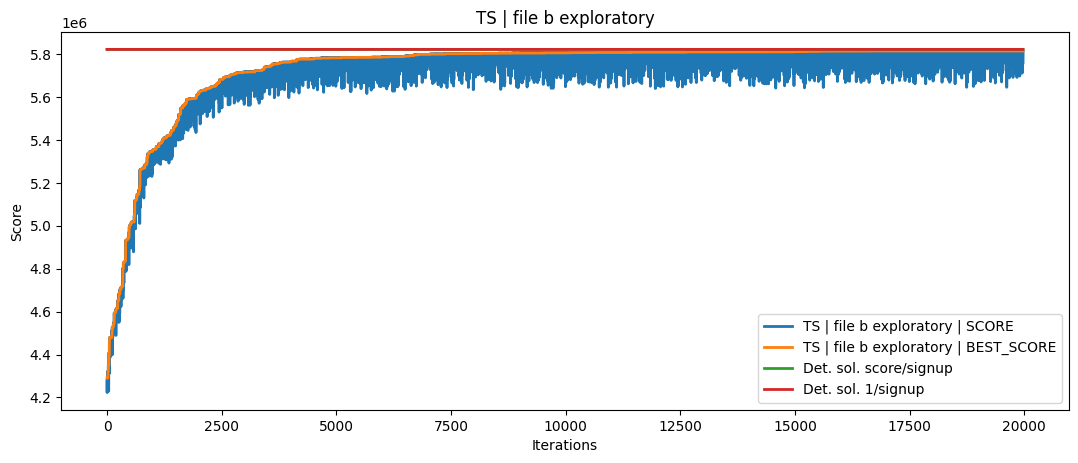

In [ ]:
# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                       Basic scenario                                    #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


files = ['b_read_on']#, 'e_so_many_books', 'f_libraries_of_the_world'] #,'c_incunabula', 'd_tough_choices']
#files = ['a_example', 'b_read_on','c_incunabula', 'd_tough_choices', 'e_so_many_books', 'f_libraries_of_the_world']
path_data = 'data/'


for file in files:

    # path to the file
    filename = path_data + file + '.txt'

    # prints the headed while we wait for the solution
    str_header = f'filename: {filename}'                                        
    print(str_header)

    # Name for logger
    log_name = 'TS | file ' + file[0] 


# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                 Initial solution setup                                  #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


    # initializes the problem for this file
    problem_TS = Problem()

    # loads the data from the file
    nr_libs, avg_nr_book = problem_TS.load_data(filename)

    # fetches the value of alpha
    alpha = df_files[df_files.file == file[0]].iloc[0]['alpha']
    alpha = round(alpha,2)

    # uncomment one of the lines below to start with a random or a fixed solution
    #p_init = problem_TS.random_solution()
    p_init = RAND_SOL_B


    params0 = {
    'nr_libs'     : nr_libs,
    'avg_nr_book' : avg_nr_book,
    'max_iter'    : 800,
    'max_iter_LS' : 25,
    'dist_L_min'  : max(1, int(0.05 * nr_libs)),
    'dist_L_max'  : max(2, int(0.5 * nr_libs)),
    'dist_B'      : 0.5,
    'tenure'      : max(7, int(math.sqrt(nr_libs))),
    'LBbal'       : alpha,
    'adaptative'  : False,
    'log_name'    : log_name + ' exploratory'
    }
    
    # Metrics to plot
    metrics = ['SCORE', 'BEST_SCORE']

    # Plot TS for this parameter values
    plotTS(problem_TS, p_init, params0, metrics)

## TS -  Hyper parameter analysis

Systematic search of the three hyper-parameters: LBbal, dist_L_min, dist_L_max

For each hyper-parameter, three values are tested and the results are plotted in a common plot. 

 5723100, 5739300, 5811300, 5748900, 5802100, 5811300, 5811300, 5811300, 5811300, 5811300, 5811300, 5761300, 5811300, 5811300, 5811300, 5811300, 5811300, 5811300, 5789700, 5811300, 5811300, 5811300, 5811300, 5780500, 5798500, 5811300, 5772300, 5811300, 5811300, 5811300, 5811300, 5811300, 5799300, 5811300, 5789700, 5811300, 5811300, 5781200, 5811300, 5811300, 5808300, 5811300, 5811300, 5754900, 5811300, 5811300, 5811300, 5811300, 5809300, 5713300, 5811300, 5811300, 5811300, 5811300, 5776200, 5811300, 5710500, 5811300, 5796600, 5811300, 5775300, 5811300, 5811300, 5811300, 5779300, 5811300, 5797300, 5744100, 5811300, 5808700, 5811300, 5802100, 5811300, 5811300, 5811300, 5811300, 5803300, 5811300, 5743700, 5799800, 5811300, 5811300, 5807500, 5811300, 5811300, 5721600, 5811300, 5811300, 5811300, 5707700, 5808300, 5811300, 5800500, 5811300, 5785700, 5811300, 5811300, 5811300, 5714700, 5712300, 5811300, 5759300, 5809200, 5811300, 5811300, 5811300, 5811300, 5811300, 5721700, 5781600, 5811300, 

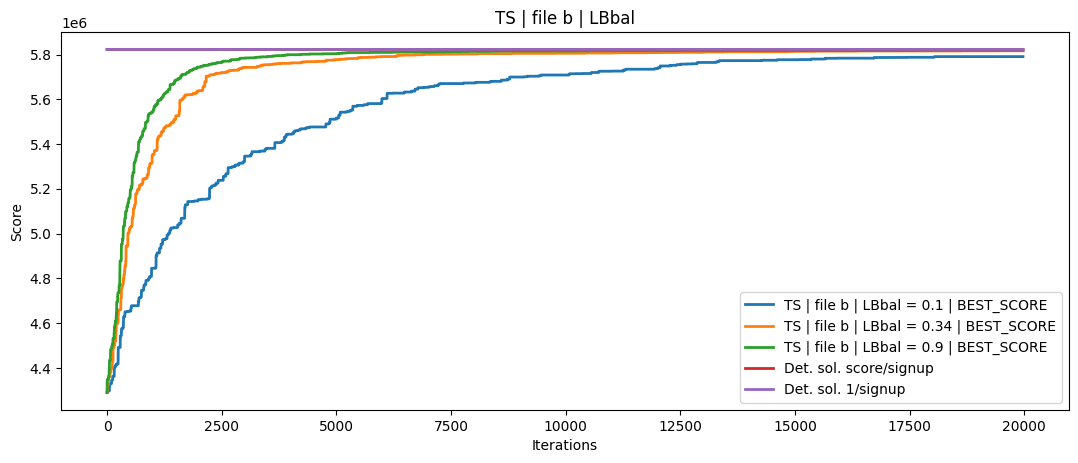

5802700, 5769700, 5743700, 5802700, 5781700, 5802700, 5765900, 5802700, 5802700, 5767600, 5802700, 5802700, 5799100, 5755000, 5777100, 5799500, 5684300, 5802700, 5802700, 5802700, 5802700, 5802700, 5802700, 5716300, 5794300, 5762700, 5795500, 5802700, 5802700, 5802700, 5802700, 5802700, 5802700, 5755400, 5800500, 5802700, 5802700, 5757700, 5802700, 5799100, 5802700, 5778900, 5802700, 5802700, 5790700, 5761700, 5729500, 5802700, 5802700, 5795500, 5802700, 5797600, 5764000, 5802700, 5801300, 5802700, 5802700, 5707800, 5790800, 5802700, 5802700, 5766700, 5677900, 5732300, 5790200, 5801400, 5802700, 5802700, 5790200, 5802700, 5802700, 5802700, 5802700, 5802700, 5802700, 5802700, 5801400, 5802700, 5790700, 5802700, 5802700, 5802700, 5784500, 5745100, 5802700, 5802700, 5802700, 5778100, 5802700, 5802700, 5802700, 5802700, 5802700, 5802700, 5795100, 5802700, 5802700, 5781100, 5725900, 5802700, 5802700, 5802700, 5798200, 5802700, 5802700, 5802700, 5802700, 5779300, 5794700, 5795900, 5802700, 5

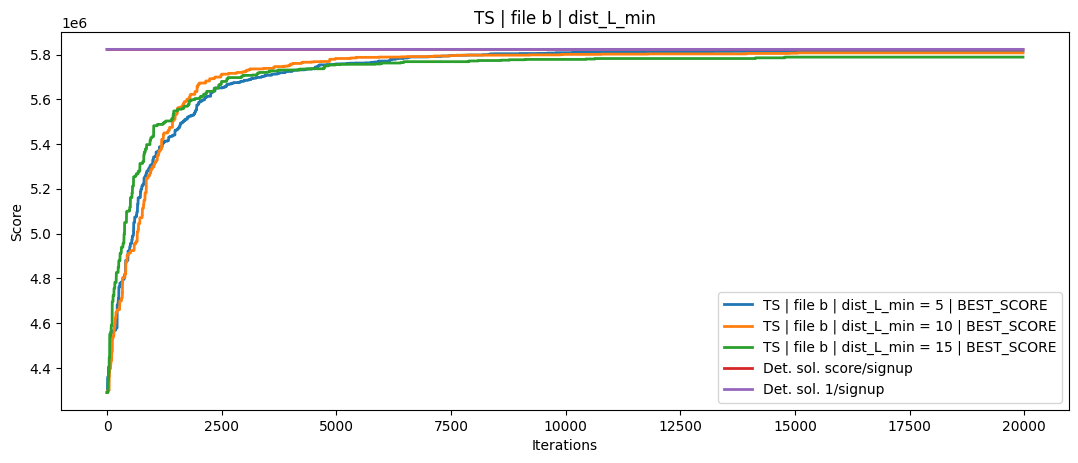

 5806600, 5803200, 5806600, 5781000, 5806600, 5806600, 5806600, 5806600, 5806600, 5806600, 5803900, 5804600, 5801200, 5701600, 5806600, 5806600, 5806600, 5806600, 5764600, 5806600, 5806600, 5792200, 5806600, 5806600, 5660400, 5806600, 5806600, 5806000, 5806600, 5799800, 5806600, 5806600, 5737000, 5806100, 5803600, 5662100, 5806600, 5806600, 5806600, 5801200, 5727300, 5806600, 5806600, 5794600, 5806600, 5806600, 5667200, 5806600, 5806600, 5806600, 5792600, 5806600, 5806600, 5806600, 5806600, 5806600, 5806600, 5806600, 5806600, 5806600, 5806600, 5806600, 5806600, 5801500, 5806600, 5806600, 5806600, 5806600, 5806600, 5697800, 5806600, 5806600, 5806600, 5806600, 5806600, 5765000, 5806600, 5806600, 5806600, 5806600, 5801800, 5770600, 5806600, 5806600, 5802600, 5806600, 5767400, 5806600, 5793600, 5806600, 5740600, 5806600, 5806600, 5806600, 5806600, 5806600, 5743900, 5806600, 5806600, 5806600, 5806600, 5806600, 5806600, 5691400, 5806600, 5806600, 5806600, 5806600, 5806600, 5770600, 5804700, 

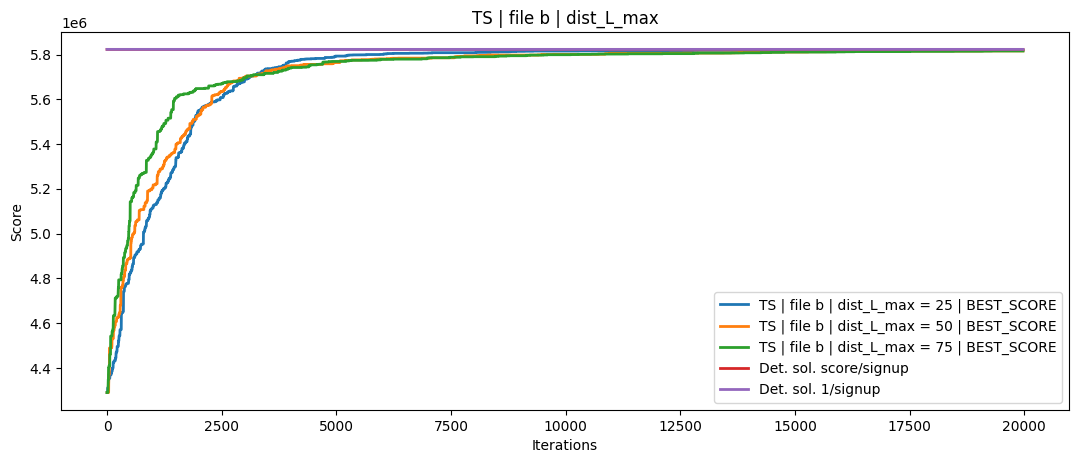

In [ ]:
# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                             TS hyperparameters analysis                                 #
#                                                                                         #
# ----------------------------------------------------------------------------------------#

# The influence of three variables on the convergence to the solution will be tested 
# The variables are LBbal, dist_L_min, dist_L_max
# LBbal = percentage of the neighbours are generated by libraries permutations and rest by books permutations
# dist_L_min =  minimum distance in libraries sequence between neighbours (5%, 15% or 25% of nr. libraries)
# dist_L_max =  maximum distance in libraries sequence between neighbours (25%, 50% or 75% of nr. libraries)


# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                   Input data loading                                    #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


files = ['b_read_on']#, 'e_so_many_books', 'f_libraries_of_the_world'] #,'c_incunabula', 'd_tough_choices']
#files = ['a_example', 'b_read_on','c_incunabula', 'd_tough_choices', 'e_so_many_books', 'f_libraries_of_the_world']
path_data = 'data/'


for file in files:

    # path to the file
    filename = path_data + file + '.txt'

    # prints the headed while we wait for the solution
    str_header = f'filename: {filename}'                                        
    print(str_header)

    # Name for logger
    log_name = 'TS | file ' + file[0] 

# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                 Initial solution setup                                  #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


    # initializes the problem for this file
    problem_TS = Problem()

    # loads the data from the file
    nr_libs, avg_nr_book = problem_TS.load_data(filename)

    # fetches the value of alpha
    alpha = df_files[df_files.file == file[0]].iloc[0]['alpha']
    alpha = round(alpha,2)

    # uncomment one of the lines below to start with a random or a fixed solution
    #p_init = problem_TS.random_solution()
    p_init = RAND_SOL_B

    params0 = {
    'nr_libs'     : nr_libs,
    'avg_nr_book' : avg_nr_book,
    'max_iter'    : 800,
    'max_iter_LS' : 25,
    'dist_L_min'  : max(1, int(0.05 * nr_libs)),
    'dist_L_max'  : max(2, int(0.5 * nr_libs)),
    'dist_B'      : 0.5,
    'tenure'      : max(7, int(math.sqrt(nr_libs))),
    'LBbal'       : alpha,
    'adaptative'  : False,
    'log_name'    : log_name
    }


# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                    Parameters testing                                   #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


    # Metrics to log
    metrics = ['BEST_SCORE']

    # defines the parameters to test and plot
    dict_params = {'LBbal'      : [0.10, alpha, 0.90], 
                   'dist_L_min' : [ max(1, int(i * 0.05 * nr_libs)) for i in range(1, 4)],
                   'dist_L_max' : [ max(2, int(i * 0.25 * nr_libs)) for i in range(1, 4)]}
     
    # Plot TS for this parameter values
    plotTS(problem_TS, p_init, params0, metrics, dict_params)

## TS - Adaptative code

The adaptative implementation of the TS algorithm is an atempt to optimize the code by using a exponential decay function which allows to have hyper-parameters whose values increases/decreases exponentially with growing number of iterations. This is used, e.g. to have larger search radius at the beginning which will decrease when the algorithm is closer to the optimum solution. 

filename: data/b_read_on.txt
load completed
nr. of libraries: 100
average nr. of books: 1000
Best value: 5822900
METHOD: TS | file b adaptative
	PARAMETERS: {'nr_libs': 100, 'avg_nr_book': 1000, 'max_iter': 800, 'max_iter_LS': 25, 'dist_L_min': 25, 'dist_L_max': 100, 'dist_B': 0.5, 'tenure': 10, 'LBbal': 0.34, 'adaptative': True, 'log_name': 'TS | file b adaptative'}
	METRICS:
		EXEC_TIME: 317
		SCORE: [4290300, 4330800, 4274700, 4287900, 4290300, 4276700, 4313300, 4290300, 4265100, 4299100, 4290300, 4290300, 4290300, 4290300, 4290300, 4237800, 4290300, 4290300, 4281800, 4290300, 4290300, 4290300, 4275300, 4290300, 4290300, 4330800, 4330800, 4330800, 4330800, 4377000, 4330800, 4330800, 4330800, 4330800, 4330800, 4337800, 4426600, 4319400, 4330800, 4330800, 4334400, 4330800, 4330800, 4330800, 4330800, 4330800, 4330800, 4330800, 4353600, 4330800, 4426600, 4421200, 4427400, 4421000, 4421400, 4429600, 4426600, 4459000, 4426600, 4426600, 4426600, 4397800, 4426600, 4426600, 4426600, 4426600,

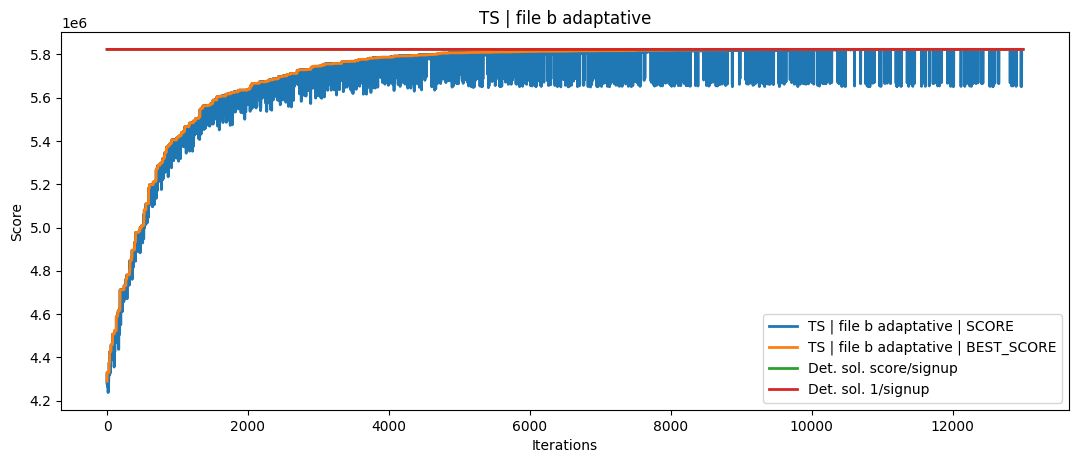

In [ ]:
# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                       Adaptative code                                   #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


files = ['b_read_on']#, 'e_so_many_books', 'f_libraries_of_the_world'] #,'c_incunabula', 'd_tough_choices']
#files = ['a_example', 'b_read_on','c_incunabula', 'd_tough_choices', 'e_so_many_books', 'f_libraries_of_the_world']
path_data = 'data/'


for file in files:

    # path to the file
    filename = path_data + file + '.txt'

    # prints the headed while we wait for the solution
    str_header = f'filename: {filename}'                                        
    print(str_header)

    # Name for logger
    log_name = 'TS | file ' + file[0] 


# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                 Initial solution setup                                  #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


    # initializes the problem for this file
    problem_TS = Problem()

    # loads the data from the file
    nr_libs, avg_nr_book = problem_TS.load_data(filename)

    # fetches the value of alpha
    alpha = df_files[df_files.file == file[0]].iloc[0]['alpha']
    alpha = round(alpha,2)

    # uncomment one of the lines below to start with a random or a fixed solution
    #p_init = problem_TS.random_solution()
    p_init = RAND_SOL_B


    params0 = {
    'nr_libs'     : nr_libs,
    'avg_nr_book' : avg_nr_book,
    'max_iter'    : 800,
    'max_iter_LS' : 25,
    'dist_L_min'  : max(1, int(0.25 * nr_libs)),
    'dist_L_max'  : max(2, int(1.0 * nr_libs)),
    'dist_B'      : 0.5,
    'tenure'      : max(7, int(math.sqrt(nr_libs))),
    'LBbal'       : alpha,
    'adaptative'  : True,
    'log_name'    : log_name + ' adaptative'
    }
    
    # Metrics to plot
    metrics = ['SCORE', 'BEST_SCORE']

    # Plot TS for this parameter values
    plotTS(problem_TS, p_init, params0, metrics)

## TS - Starting with the score/signup solution

Files, b, c, d and f have a best deterministic solution when sorting the libraries by the score/signup heuristic. 

Apart from file d, all others have a optimum solutions with the same score as this deterministic solution.

filename: data/b_read_on.txt
load completed
nr. of libraries: 100
average nr. of books: 1000
Best value: 5822900
METHOD: TS | b adaptative
	PARAMETERS: {'nr_libs': 100, 'avg_nr_book': 1000, 'max_iter': 2000, 'max_iter_LS': 25, 'dist_L_min': 25, 'dist_L_max': 100, 'dist_B': 0.5, 'tenure': 10, 'LBbal': 0.34, 'adaptative': True, 'log_name': 'TS | b adaptative'}
	METRICS:
		EXEC_TIME: 122
		SCORE: [5819500, 5822900, 5822900, 5776900, 5822900, 5811900, 5822900, 5738900, 5822900, 5822900, 5822900, 5822900, 5822900, 5822900, 5822900, 5822900, 5822900, 5822900, 5753300, 5822900, 5822900, 5822900, 5822900, 5812900, 5822500, 5822900, 5698100, 5822900, 5822900, 5822900, 5822900, 5822900, 5815700, 5822900, 5822900, 5769000, 5822700, 5790100, 5822900, 5822900, 5750900, 5822900, 5802600, 5822900, 5804700, 5822900, 5815700, 5822900, 5822900, 5822900, 5795600, 5822900, 5822000, 5819000, 5822900, 5822900, 5822900, 5800500, 5822900, 5753300, 5717900, 5730500, 5822900, 5822900, 5686900, 5822900, 5766800,

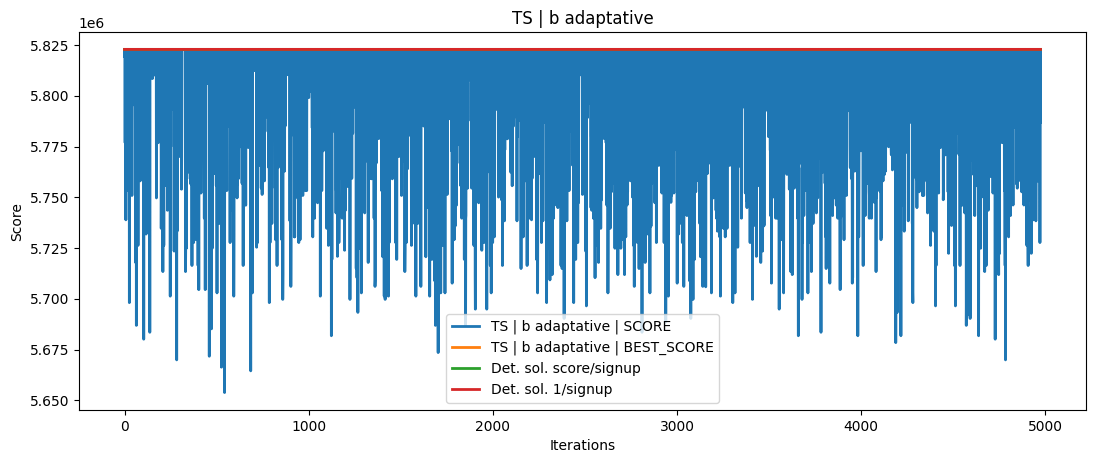

filename: data/f_libraries_of_the_world.txt
load completed
nr. of libraries: 1000
average nr. of books: 509
Best value: 5227905
METHOD: TS | f adaptative
	PARAMETERS: {'nr_libs': 1000, 'avg_nr_book': 509, 'max_iter': 2000, 'max_iter_LS': 25, 'dist_L_min': 250, 'dist_L_max': 1000, 'dist_B': 0.5, 'tenure': 31, 'LBbal': 0.5, 'adaptative': True, 'log_name': 'TS | f adaptative'}
	METRICS:
		EXEC_TIME: 61
		SCORE: [5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 4452367, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 3516736, 5227905, 3424339, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5227905, 5220263, 5227905, 52

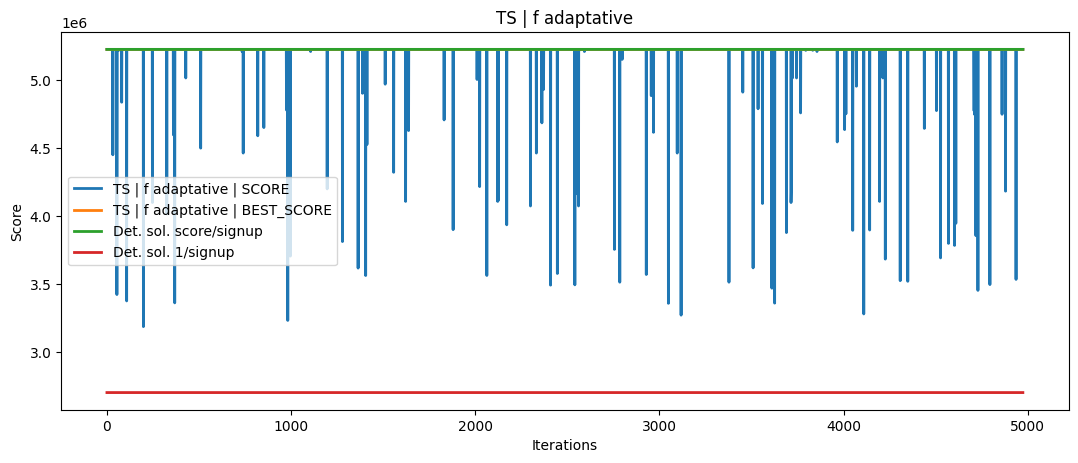

filename: data/c_incunabula.txt
load completed
nr. of libraries: 10000
average nr. of books: 15
Best value: 5645747
METHOD: TS | c adaptative
	PARAMETERS: {'nr_libs': 10000, 'avg_nr_book': 15, 'max_iter': 2000, 'max_iter_LS': 25, 'dist_L_min': 2500, 'dist_L_max': 10000, 'dist_B': 0.5, 'tenure': 100, 'LBbal': 0.75, 'adaptative': True, 'log_name': 'TS | c adaptative'}
	METRICS:
		EXEC_TIME: 387
		SCORE: [5645747, 5640008, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5641958, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5632146, 5645747, 5631666, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5619363, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5645747, 5642823, 5633836, 5645747, 5638961, 5645747, 5645747, 

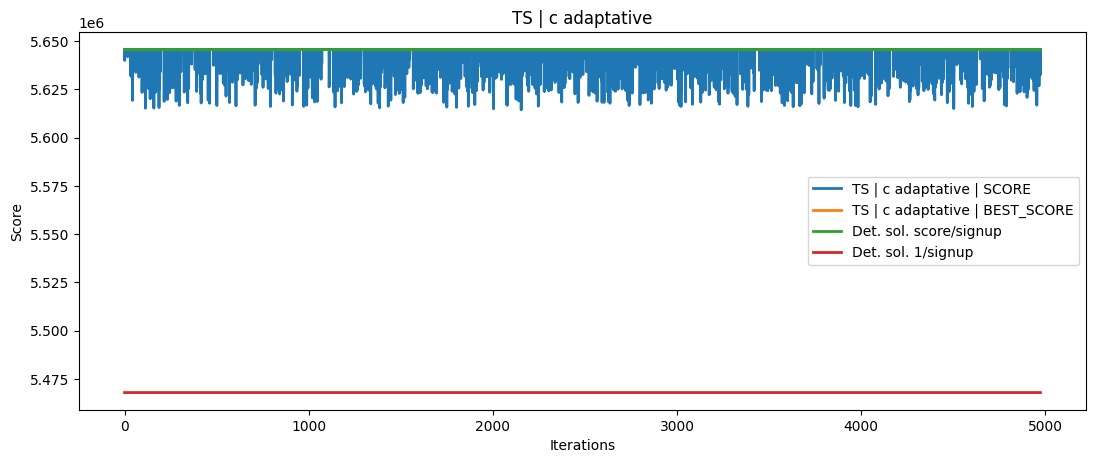

55, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866160, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866225, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866225, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 4866355, 486635

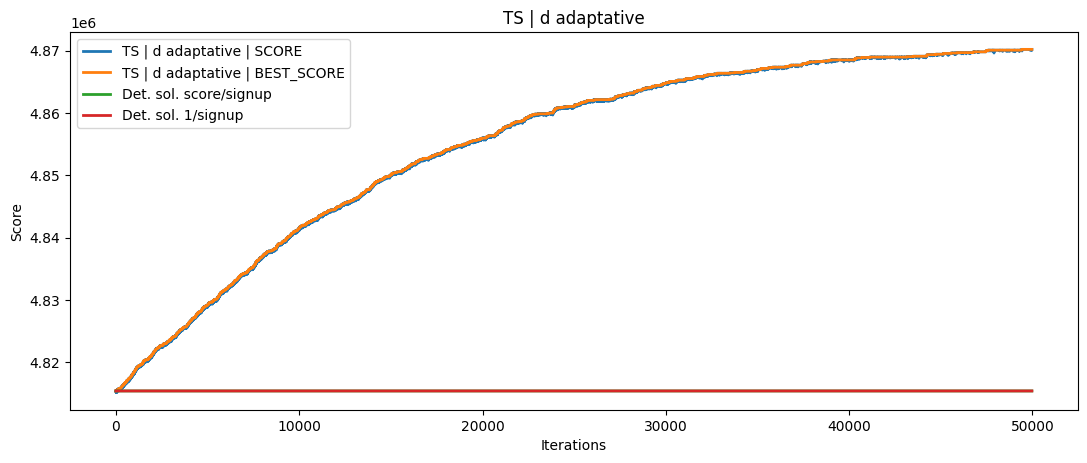

In [ ]:
# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                   Starting with the score/signup solution                               #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


files = ['b_read_on', 'f_libraries_of_the_world','c_incunabula', 'd_tough_choices']
#files = ['a_example', 'b_read_on','c_incunabula', 'd_tough_choices', 'e_so_many_books', 'f_libraries_of_the_world']
path_data = 'data/'


for file in files:


    # path to the file
    filename = path_data + file + '.txt'

    # prints the headed while we wait for the solution
    str_header = f'filename: {filename}'                                        
    print(str_header)

    # Name for logger
    log_name = 'TS | file ' + file[0] 


# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                 Initial solution setup                                  #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


    # initializes the problem for this file
    problem_TS = Problem()

    # loads the data from the file
    nr_libs, avg_nr_book = problem_TS.load_data(filename)

    # fetches the value of alpha
    alpha = df_files[df_files.file == file[0]].iloc[0]['alpha']
    alpha = round(alpha,2)

    # initial solution
    p_init = problem_TS.score_signup_solution()

    # name to show in the logger
    log_name = 'TS | ' + str(file[0])

    params0 = {
    'nr_libs'     : nr_libs,
    'avg_nr_book' : avg_nr_book,
    'max_iter'    : 2000,
    'max_iter_LS' : 25,
    'dist_L_min'  : max(1, int(0.25 * nr_libs)),
    'dist_L_max'  : max(2, int(1.0 * nr_libs)),
    'dist_B'      : 0.5,
    'tenure'      : max(7, int(math.sqrt(nr_libs))),
    'LBbal'       : alpha,
    'adaptative'  : True,
    'log_name'    : log_name + ' adaptative'
    }

    # Metrics to plot
    metrics = ['SCORE', 'BEST_SCORE']

    # Plot TS for this parameter values
    plotTS(problem_TS, p_init, params0, metrics)

## TS - Starting with the 1/signup solution

File e is the only problem where the best deterministic solution corresponds to the 1/signup solution sorting.

The optimum solution exceeds the value of the best deterministic solution.

681, 4287542, 4287542, 4287542, 4287542, 4287542, 4287542, 4287542, 4287681, 4287681, 4287681, 4287681, 4287808, 4287681, 4287681, 4287681, 4287681, 4287681, 4287681, 4287681, 4286338, 4287681, 4287681, 4287681, 4287681, 4287681, 4287681, 4287681, 4287681, 4287681, 4287681, 4287681, 4287681, 4287808, 4287808, 4287808, 4287808, 4287808, 4286490, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4286902, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4285858, 4287808, 4287808, 4287808, 4287808, 4287808, 4287569, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4282332, 4287808, 4287808, 4286497, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4286213, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 4287808, 42878

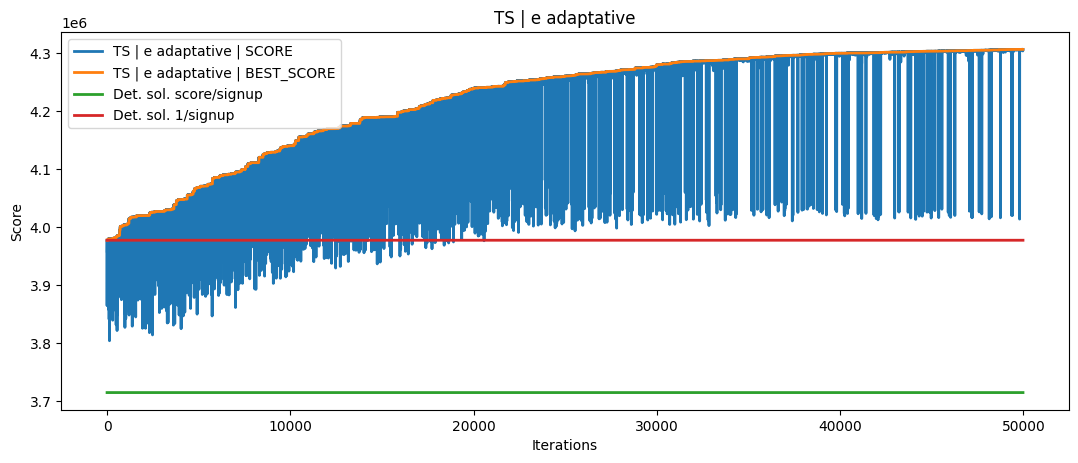

In [ ]:
# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                     Starting with the 1/signup solution                                 #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


files = [ 'e_so_many_books']
#files = ['a_example', 'b_read_on','c_incunabula', 'd_tough_choices', 'e_so_many_books', 'f_libraries_of_the_world']
path_data = 'data/'


for file in files:

    # path to the file
    filename = path_data + file + '.txt'

    # prints the headed while we wait for the solution
    str_header = f'filename: {filename}'                                        
    print(str_header)

    # Name for logger
    log_name = 'TS | file ' + file[0] 


# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                 Initial solution setup                                  #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


    # initializes the problem for this file
    problem_TS = Problem()

    # loads the data from the file
    nr_libs, avg_nr_book = problem_TS.load_data(filename)

    # fetches the value of alpha
    alpha = df_files[df_files.file == file[0]].iloc[0]['alpha']
    alpha = round(alpha,2)

    # initial solution
    p_init = problem_TS.signup_solution()

    # name to show in the logger
    log_name = 'TS | ' + str(file[0])

    params0 = {
    'nr_libs'     : nr_libs,
    'avg_nr_book' : avg_nr_book,
    'max_iter'    : 2000,
    'max_iter_LS' : 25,
    'dist_L_min'  : max(1, int(0.05 * nr_libs)),
    'dist_L_max'  : max(2, int(0.5 * nr_libs)),
    'dist_B'      : 0.5,
    'tenure'      : max(7, int(math.sqrt(nr_libs))),
    'LBbal'       : alpha,
    'adaptative'  : True,
    'log_name'    : log_name + ' adaptative'
    }
    
    # Metrics to plot
    metrics = ['SCORE', 'BEST_SCORE']

    # Plot TS for this parameter values
    plotTS(problem_TS, p_init, params0, metrics)

## TS - Exploring files e and f


In this block the solutions to the problems of files e and f are searched starting from a random initial solution.

, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814, 2020814,

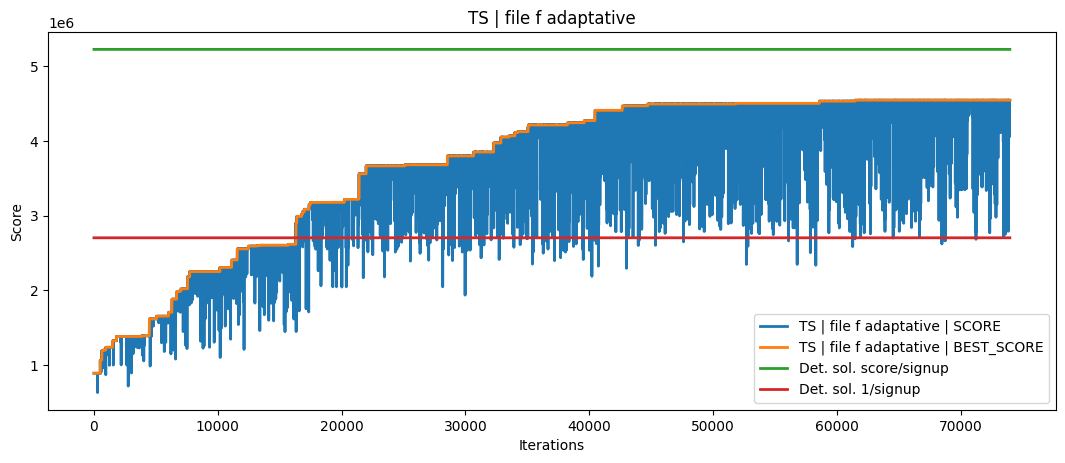

 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3491001, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 3492130, 

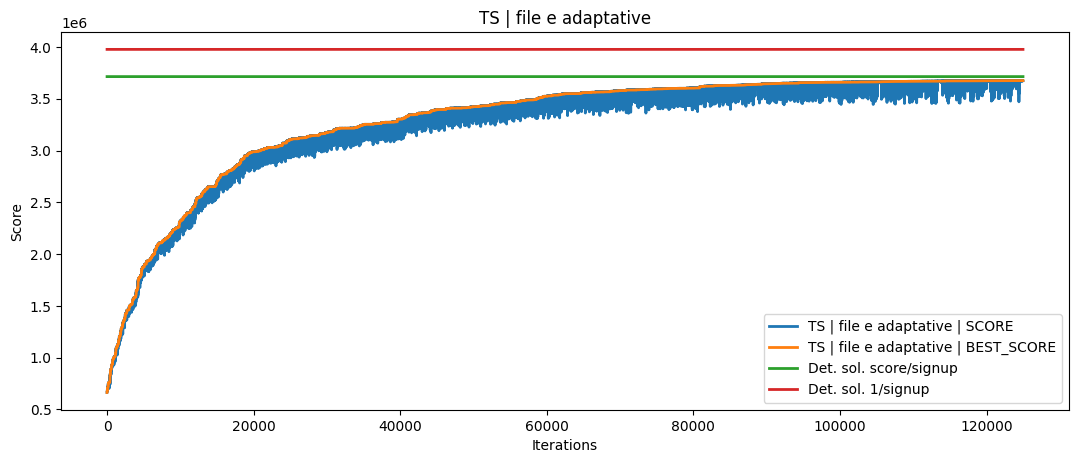

In [ ]:
# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                 Exploring files e and f                                 #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


files = ['f_libraries_of_the_world', 'e_so_many_books'] #,'c_incunabula', 'd_tough_choices']
#files = ['a_example', 'b_read_on','c_incunabula', 'd_tough_choices', 'e_so_many_books', 'f_libraries_of_the_world']
path_data = 'data/'


for file in files:

    # path to the file
    filename = path_data + file + '.txt'

    # prints the headed while we wait for the solution
    str_header = f'filename: {filename}'                                        
    print(str_header)

    # Name for logger
    log_name = 'TS | file ' + file[0] 


# ----------------------------------------------------------------------------------------#
#                                                                                         #
#                                 Initial solution setup                                  #
#                                                                                         #
# ----------------------------------------------------------------------------------------#


    # initializes the problem for this file
    problem_TS = Problem()

    # loads the data from the file
    nr_libs, avg_nr_book = problem_TS.load_data(filename)

    # fetches the value of alpha
    alpha = df_files[df_files.file == file[0]].iloc[0]['alpha']
    alpha = round(alpha,2)

    # initial solution
    p_init = problem_TS.random_solution()

    params0 = {
    'nr_libs'     : nr_libs,
    'avg_nr_book' : avg_nr_book,
    'max_iter'    : 5000,
    'max_iter_LS' : 25,
    'dist_L_min'  : max(1, int(0.25 * (nr_libs - 1))),
    'dist_L_max'  : max(2, int(1.0 * (nr_libs - 1))),
    'dist_B'      : 0.5,
    'tenure'      : max(7, int(math.sqrt(nr_libs))),
    'LBbal'       : 0.95,
    'adaptative'  : True,
    'log_name'    : log_name + ' adaptative'
    }

    # Metrics to plot
    metrics = ['SCORE', 'BEST_SCORE']

    # Plot TS for this parameter values
    plotTS(problem_TS, p_init, params0, metrics)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=590b533a-14dc-4632-bd1d-c99831028fae' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>